<h1 style="font-size: 64px">EDA for Anime dataset</h1>

<h2 style="font-size: 48px">Importing modules</h2>

In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import seaborn as sns
import collections as coll
from sklearn.cluster import KMeans
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import missingno as msno
import spacy
nlp = spacy.load('en_core_web_sm')
#Lets add some style
sns.set_style("dark")
import warnings
warnings.simplefilter(action='ignore')
import ast

/home/anton/Desktop/notebook/jupyterenv/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/anton/Desktop/notebook/jupyterenv/lib/python3.10/site-packages/torch/cuda/__init__.py:529: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


<h2 style="font-size: 36px">Load general data about Anime</h2>

In [2]:
df_general = pd.read_csv("Anime_general_complete.csv")
df_general.drop(["Unnamed: 0", "Premiered"], axis="columns", inplace=True)
df_general["Duration"] = df_general["Duration"].astype("int64")
df_general["Rating"] = df_general["Rating"].apply(lambda x: "G - All Ages" if x == "None" else x)
df_general["Episodes"] = df_general["Episodes"].apply(lambda x: 1 if x == 0 else x)
df_general["Description"].fillna(df_general["Title"], inplace=True)

### Status should not be relevant to us whatsoevere. Check it and delete

In [3]:
df_general["Status"].value_counts()

Finished Airing     18457
Currently Airing      281
Name: Status, dtype: int64

In [4]:
df_general.drop("Status", axis="columns", inplace=True)

# Maybe delete languages? Just concantenate them to synonyms and be done with it. Like... What is the point even?

In [5]:
df_general["English"][df_general["English"].where(df_general["English"] == "No English").dropna().index] = np.NaN
df_general["French"][df_general["French"].where(df_general["French"] == "No French").dropna().index] = np.NaN
df_general["German"][df_general["German"].where(df_general["German"] == "No German").dropna().index] = np.NaN
df_general["Japanese"][df_general["Japanese"].where(df_general["Japanese"] == "No Japanese").dropna().index] = np.NaN
df_general["Spanish"][df_general["Spanish"].where(df_general["Spanish"] == "No Spanish").dropna().index] = np.NaN

In [6]:
df_general["Synonyms"][df_general["English"].dropna().index] += ", " + df_general["English"].dropna()
df_general["Synonyms"][df_general["French"].dropna().index] += ", " + df_general["French"].dropna()
df_general["Synonyms"][df_general["German"].dropna().index] += ", " + df_general["German"].dropna()
df_general["Synonyms"][df_general["Japanese"].dropna().index] += ", " + df_general["Japanese"].dropna()
df_general["Synonyms"][df_general["Spanish"].dropna().index] += ", " + df_general["Spanish"].dropna()

In [7]:
df_general.drop(["English", "French", "German", "Japanese", "Spanish"], axis="columns", inplace=True)

### Most basic look at Demographics and Rating. To look more in depth, check preprocess notebook.

In [8]:
temp_df = df_general["Aired"].where(df_general["Episodes"] == "Unknown").dropna()
for aired, index in zip(temp_df, temp_df.index):
    try:
        df_general["Episodes"][index] = round(365 / 7 * (2022 - int(re.findall("\d{4}", aired)[0])))
    except:
        df_general["Episodes"][index] = "Unknown"
df_general.drop(df_general.where(df_general["Episodes"] == "Unknown").dropna().index, inplace=True)
df_general["Episodes"] = df_general["Episodes"].astype("int64")

In [9]:
durrat = pd.DataFrame(columns=df_general["Rating"].unique(), index=df_general["Duration"].unique()).fillna(0)
for rating in durrat.columns:
    buffer = df_general["Duration"].where(df_general["Rating"] == rating).dropna().value_counts()
    durrat[rating][buffer.index] += buffer
durrat = durrat.sort_index()

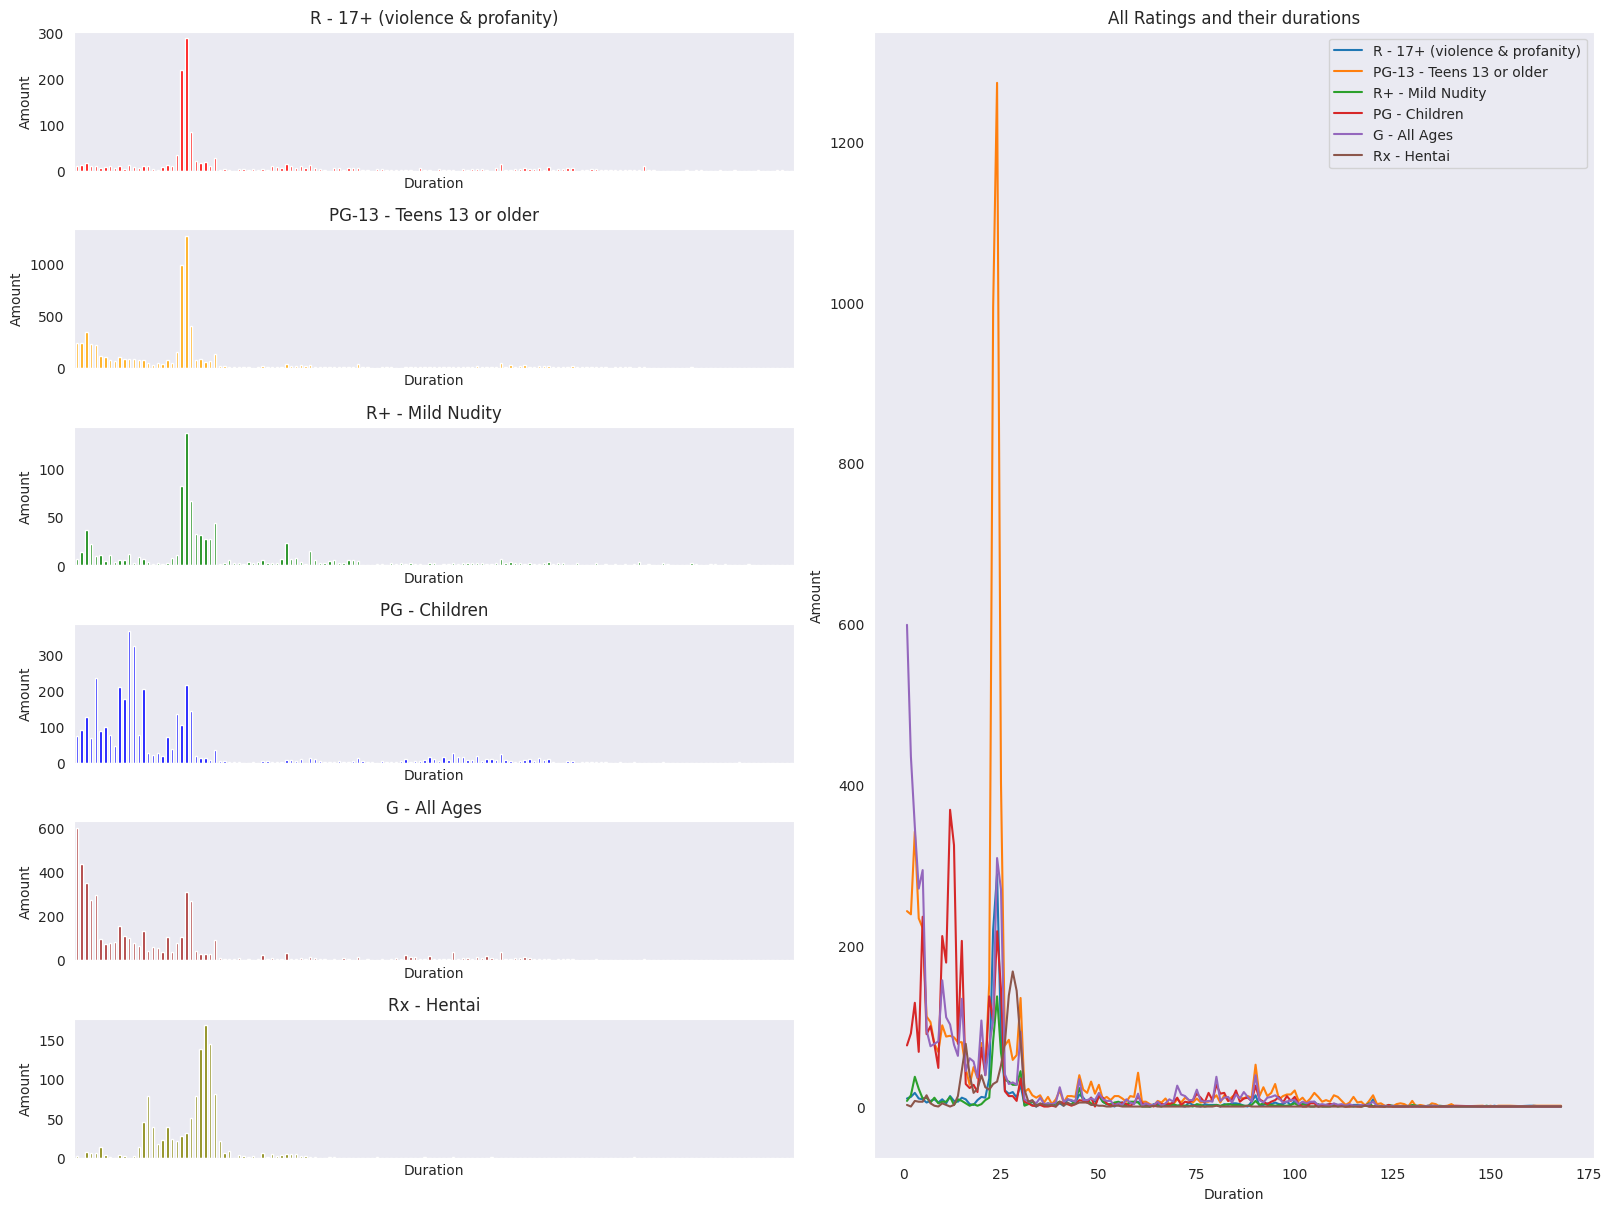

In [10]:
fig = plt.figure(figsize=(16,12), constrained_layout=True)
gs = mpl.gridspec.GridSpec(6, 2, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[3,0])
ax5 = fig.add_subplot(gs[4,0])
ax6 = fig.add_subplot(gs[5,0])
ax7 = fig.add_subplot(gs[:,1])
fig.subplots_adjust(hspace=0.5)

colors=["red", "orange", "green", "blue", "brown", "olive"]
durrat["R - 17+ (violence & profanity)"].plot(ax=ax1, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[0], title='R - 17+ (violence & profanity)', xticks=[])
durrat["PG-13 - Teens 13 or older"].plot(ax=ax2, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[1], title="PG-13 - Teens 13 or older", xticks=[])
durrat["R+ - Mild Nudity"].plot(ax=ax3, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[2], title="R+ - Mild Nudity", xticks=[])
durrat["PG - Children"].plot(ax=ax4, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[3], title="PG - Children", xticks=[])
durrat["G - All Ages"].plot(ax=ax5, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[4], title="G - All Ages", xticks=[])
durrat["Rx - Hentai"].plot(ax=ax6, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[5], title="Rx - Hentai", xticks=[])
durrat.plot(ax=ax7, xlabel="Duration", ylabel="Amount", title="All Ratings and their durations");

In [11]:
durdem = pd.DataFrame(columns=df_general["Demographics"].unique(), index=df_general["Duration"].unique()).fillna(0)
for demographic in durdem.columns:
    buffer = df_general["Duration"].where(df_general["Demographics"] == demographic).dropna().value_counts()
    durdem[demographic][buffer.index] += buffer
durdem = durdem.sort_index()

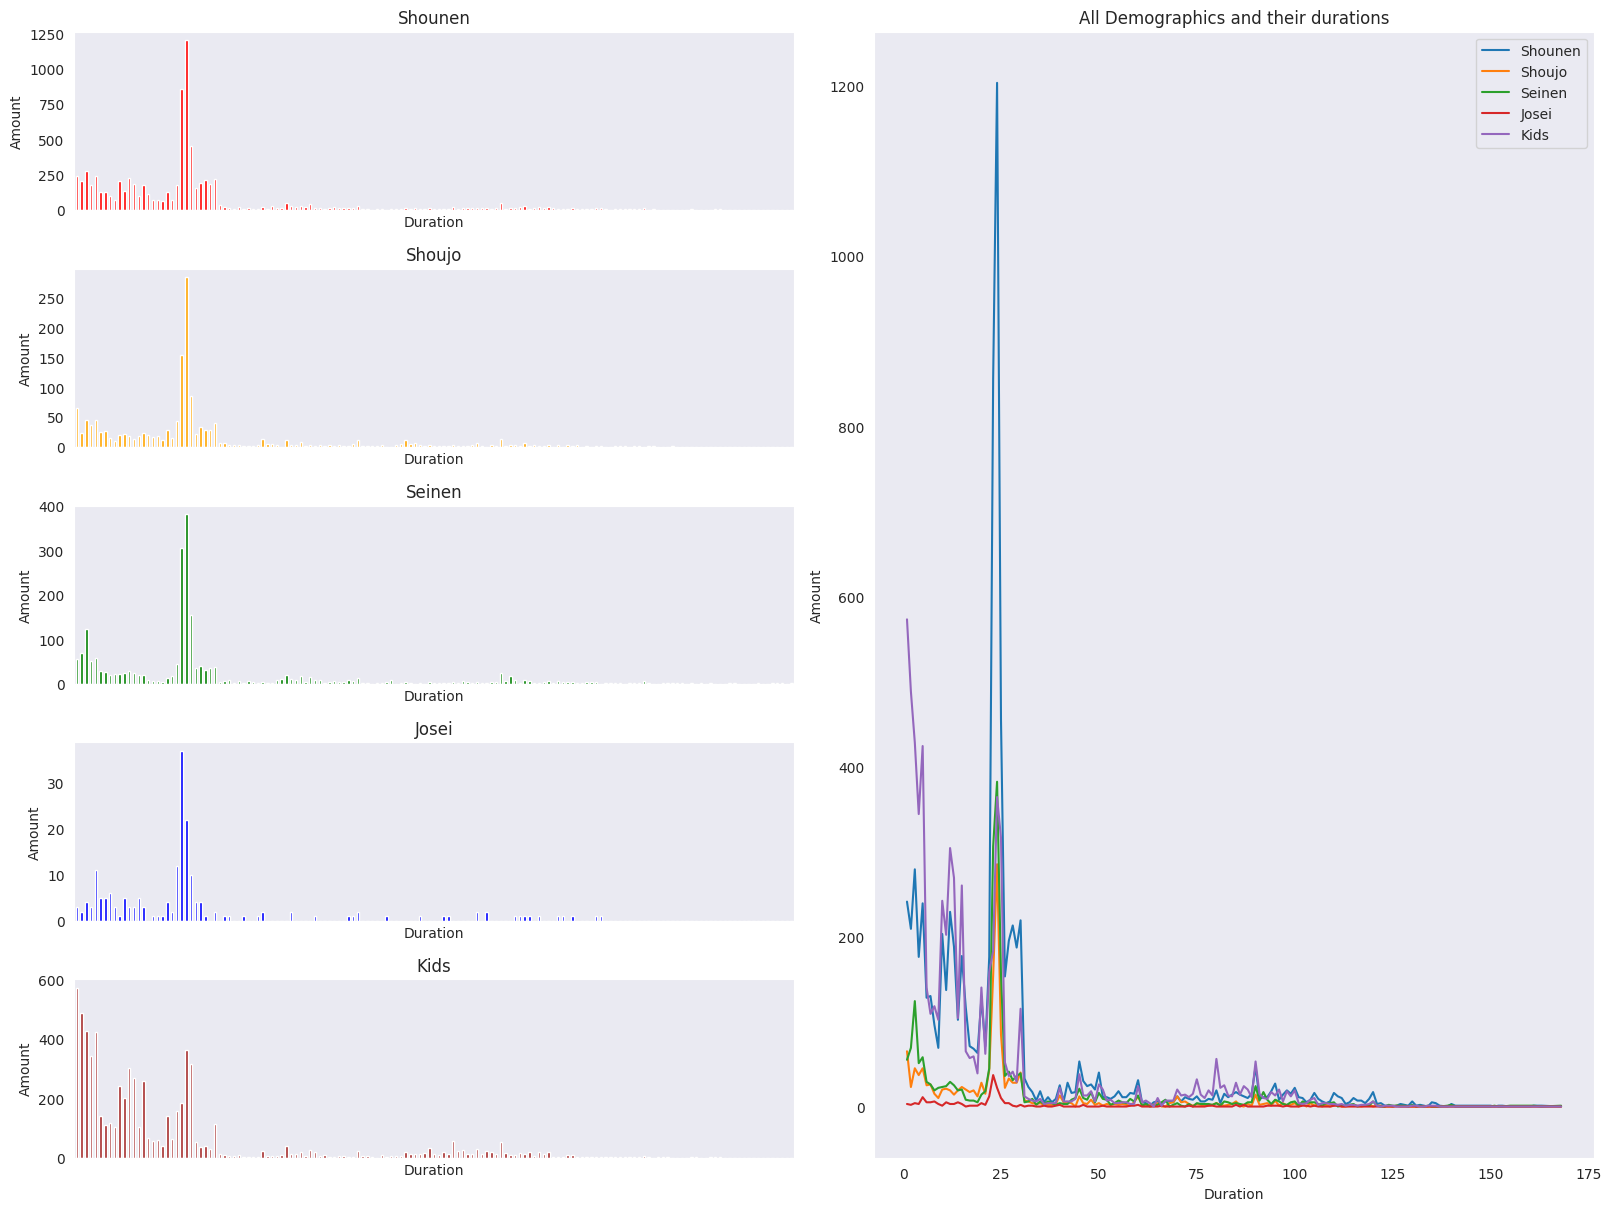

In [12]:
fig = plt.figure(figsize=(16,12), constrained_layout=True)
gs = mpl.gridspec.GridSpec(5, 2, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[3,0])
ax5 = fig.add_subplot(gs[4,0])
ax6 = fig.add_subplot(gs[:,1])
fig.subplots_adjust(hspace=0.5)

colors=["red", "orange", "green", "blue", "brown"]
durdem["Shounen"].plot(ax=ax1, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[0], title="Shounen", xticks=[])
durdem["Shoujo"].plot(ax=ax2, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[1], title="Shoujo", xticks=[])
durdem["Seinen"].plot(ax=ax3, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[2], title="Seinen", xticks=[])
durdem["Josei"].plot(ax=ax4, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[3], title="Josei", xticks=[])
durdem["Kids"].plot(ax=ax5, xlabel="Duration", ylabel="Amount", kind="bar", color=colors[4], title="Kids", xticks=[])
durdem.plot(ax=ax6, xlabel="Duration", ylabel="Amount", title="All Demographics and their durations");

## Genres, Themes and Source analysys

In [13]:
genres = set()
themes = set()
for genre, theme in zip(df_general["Genres"], df_general["Themes"]):
    if isinstance(genre, str):
        for j in genre.split(", "):
            genres.add(j)
    if isinstance(theme, str):
        for j in theme.split(", "):
            themes.add(j)
genres, themes = pd.Series(index=list(genres)).fillna(0), pd.Series(index=list(themes)).fillna(0)
for genre, theme in zip(df_general["Genres"], df_general["Themes"]):
    for j in genre.split(", "):
        genres[j] += 1
    for j in theme.split(", "):
        themes[j] += 1

In [14]:
genres

Horror            411.0
Fantasy          6346.0
Suspense          171.0
Supernatural     2449.0
Slice of Life    1519.0
Comedy           6081.0
Gourmet           112.0
Girls Love        101.0
Boys Love         148.0
Hentai           1162.0
Award Winning    3172.0
Sports            609.0
Romance          3391.0
Mystery           717.0
Adventure        6033.0
Action           4018.0
Avant Garde       147.0
Erotica            31.0
Sci-Fi           2863.0
Ecchi             742.0
Drama            4110.0
dtype: float64

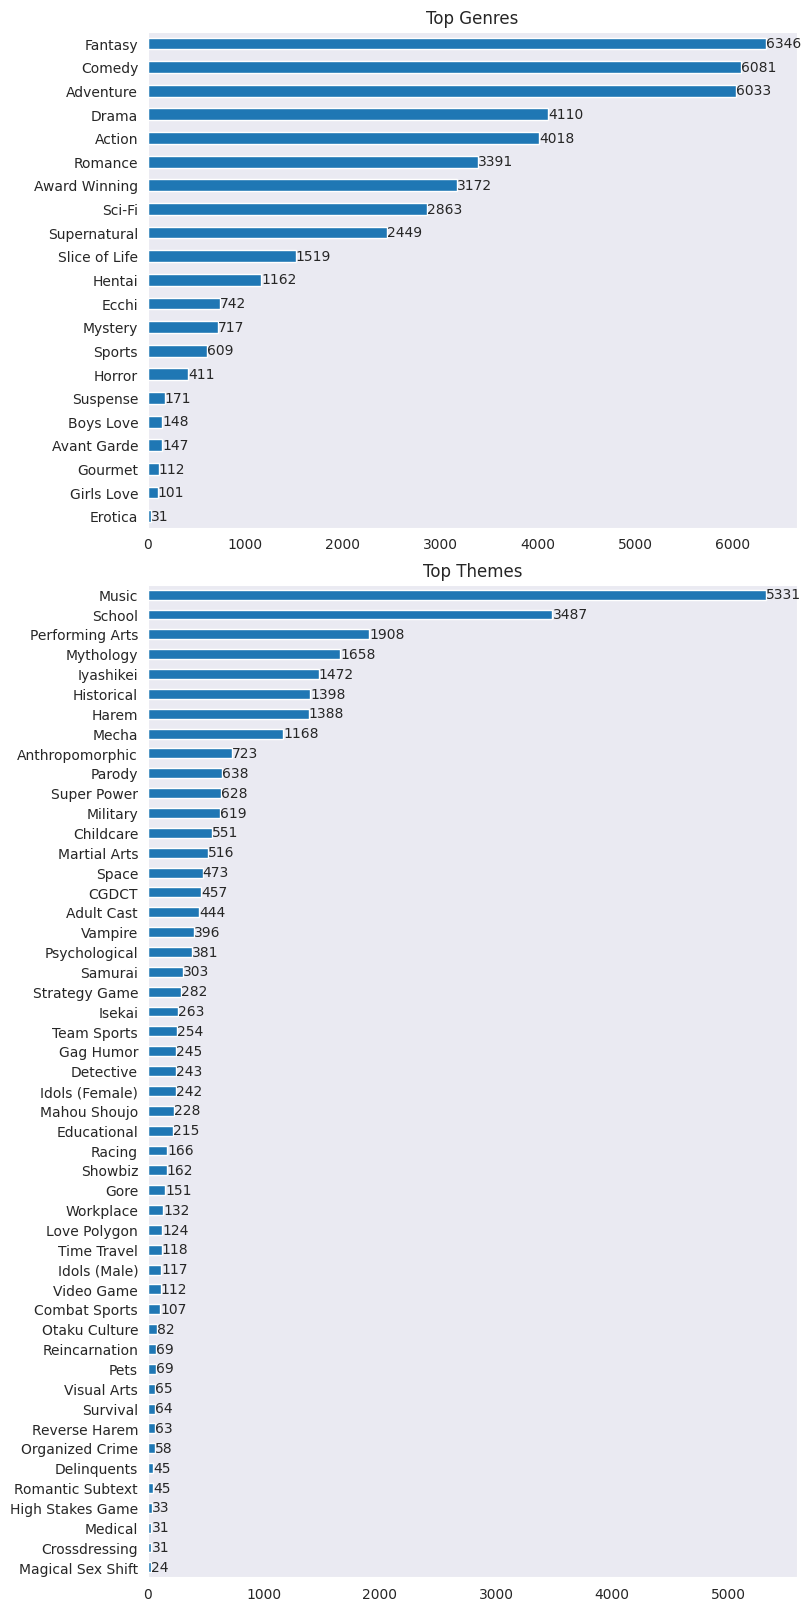

In [15]:
fig = plt.figure(figsize=(8,16), constrained_layout=True)
gs = mpl.gridspec.GridSpec(3, 1, figure=fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1:])

genres.sort_values().plot(ax=ax1, kind="barh", title="Top Genres");
ax1.bar_label(ax1.containers[0]);
themes.sort_values().plot(ax=ax2, kind="barh", title="Top Themes");
ax2.bar_label(ax2.containers[0]);

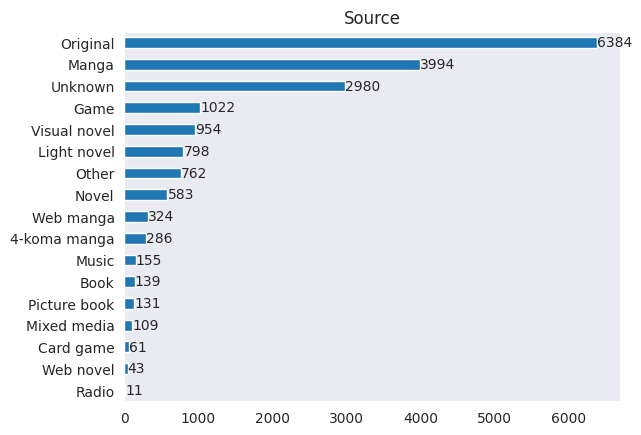

In [16]:
ax = df_general["Source"].value_counts().sort_values().plot(kind="barh", title="Source");
ax.bar_label(ax.containers[0]);

In [17]:
genre_theme = pd.DataFrame(index=genres.index, columns=themes.index).fillna(0)

In [18]:
genre_genre = pd.DataFrame(index=genres.index, columns=genres.index).fillna(0)

In [19]:
theme_theme = pd.DataFrame(index=themes.index, columns=themes.index).fillna(0)

## Themes combined with other themes

In [20]:
for genre, theme in zip(df_general["Themes"], df_general["Themes"]):
    theme_theme[theme.split(", ")] = theme_theme[theme.split(", ")].T.apply(lambda x: x + 1 if x.name in genre.split(", ") else x).T
theme_theme_percent = theme_theme.copy()
for i in theme_theme_percent.columns:
    theme_theme_percent[i] /= theme_theme_percent[i][i]

In [21]:
theme_theme.style.background_gradient(cmap ='coolwarm')

In [22]:
theme_theme_percent.style.background_gradient(cmap ='coolwarm')

In [23]:
theme_theme.corr().style.background_gradient(cmap ='coolwarm')

## Genres combined with genres

In [24]:
for genre, theme in zip(df_general["Genres"], df_general["Genres"]):
    genre_genre[theme.split(", ")] = genre_genre[theme.split(", ")].T.apply(lambda x: x + 1 if x.name in genre.split(", ") else x).T
genre_genre_percent = genre_genre.copy()
for i in genre_genre_percent.columns:
    genre_genre_percent[i] /= genre_genre_percent[i][i]

In [25]:
genre_genre.style.background_gradient(cmap ='coolwarm')

In [26]:
genre_genre_percent.style.background_gradient(cmap ='coolwarm')

In [27]:
genre_genre.corr().style.background_gradient(cmap ='coolwarm')

## Genres combined with Themes

In [28]:
for genre, theme in zip(df_general["Genres"], df_general["Themes"]):
    genre_theme[theme.split(", ")] = genre_theme[theme.split(", ")].T.apply(lambda x: x + 1 if x.name in genre.split(", ") else x).T

In [29]:
genre_theme.index

Index(['Horror', 'Fantasy', 'Suspense', 'Supernatural', 'Slice of Life',
       'Comedy', 'Gourmet', 'Girls Love', 'Boys Love', 'Hentai',
       'Award Winning', 'Sports', 'Romance', 'Mystery', 'Adventure', 'Action',
       'Avant Garde', 'Erotica', 'Sci-Fi', 'Ecchi', 'Drama'],
      dtype='object')

In [30]:
genre_theme.style.background_gradient(cmap ='coolwarm')

In [31]:
genre_theme.corr().style.background_gradient(cmap ='coolwarm')

In [32]:
genre_theme[["Strategy Game", "Magical Sex Shift"]]

Strategy Game  Magical Sex Shift
Horror                     2                  0
Fantasy                  144                  9
Suspense                   5                  0
Supernatural               8                  2
Slice of Life             23                  3
Comedy                    60                 22
Gourmet                    1                  0
Girls Love                 0                  4
Boys Love                  0                  2
Hentai                     0                  2
Award Winning             54                  0
Sports                    10                  0
Romance                   42                  9
Mystery                    8                  1
Adventure                103                  8
Action                    86                  7
Avant Garde                1                  0
Erotica                    0                  0
Sci-Fi                    31                  0
Ecchi                      8                  4
Drama                     61                  4

### Cause there is too little information to work with on some examples, correlation group two absolutely unreleated themes as highly correlated. To somehow change this situation exponentiate all values in table

In [33]:
genre_theme_square = genre_theme ** 2

In [34]:
genre_theme_square.corr().style.background_gradient(cmap ='coolwarm')

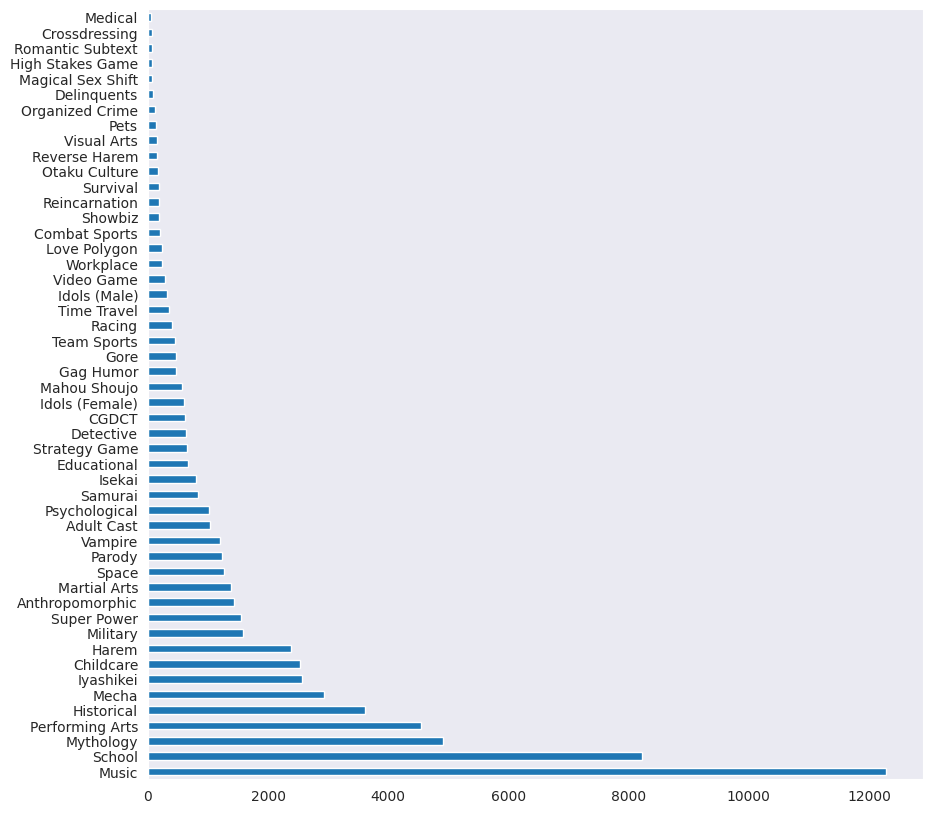

In [35]:
genre_theme.sum().sort_values(ascending=False).plot(kind="barh", figsize=(10, 10));

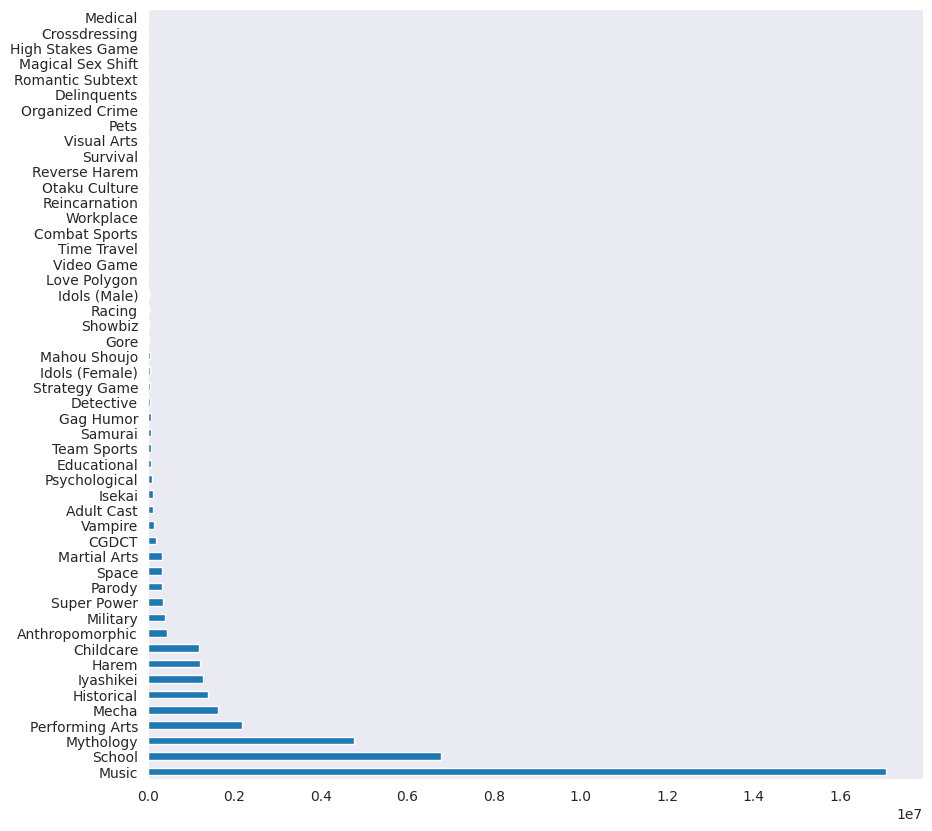

In [36]:
genre_theme_square.sum().sort_values(ascending=False).plot(kind="barh", figsize=(10, 10));

In [37]:
genre_theme.T.corr().style.background_gradient(cmap ='coolwarm')

In [38]:
genre_theme_square.T.corr().style.background_gradient(cmap ='coolwarm')

# New wave of combined columns!          
> __genre with source    
> theme with source       
> theme with rating        
> genre with rating__

In [39]:
gensource = pd.DataFrame(columns=df_general["Source"].value_counts().index, 
                          index=genres.index).fillna(0)

In [40]:
themesource = pd.DataFrame(columns=df_general["Source"].value_counts().index, 
                          index=themes.index).fillna(0)

In [41]:
themerating = pd.DataFrame(columns=df_general["Rating"].value_counts().index, 
                          index=themes.index).fillna(0)

In [42]:
genrating = pd.DataFrame(columns=df_general["Rating"].value_counts().index, 
                         index=genres.index).fillna(0)

In [43]:
for genre in genrating.index:
    buffer = df_general["Rating"].where(df_general["Genres"].str.find(genre) > -1).dropna().value_counts()
    for rating in buffer.index:
        genrating[rating][genre] += buffer[rating]

In [44]:
for theme in themerating.index:
    buffer = df_general["Rating"].where(df_general["Themes"].str.find(theme) > -1).dropna().value_counts()
    for rating in buffer.index:
        themerating[rating][theme] += buffer[rating]

In [45]:
for genre in gensource.index:
    buffer = df_general["Source"].where(df_general["Genres"].str.find(genre) > -1).dropna().value_counts()
    for source in buffer.index:
        gensource[source][genre] += buffer[source]

In [46]:
for theme in themesource.index:
    buffer = df_general["Source"].where(df_general["Themes"].str.find(theme) > -1).dropna().value_counts()
    for source in buffer.index:
        themesource[source][theme] += buffer[source]

In [47]:
gensource.style.background_gradient(cmap ='coolwarm')

In [48]:
print("MOST FREQUENT GENRE PER SOURCE:\n")
for source in gensource.columns:
    buffer = gensource[source].where(gensource[source] == gensource[source].max()).dropna()
    print(f"{source} => {buffer.index.values[0]}: {buffer.values[0]}")

MOST FREQUENT GENRE PER SOURCE:

Original => Adventure: 2550.0
Manga => Comedy: 1870.0
Unknown => Adventure: 1225.0
Game => Fantasy: 541.0
Visual novel => Hentai: 583.0
Light novel => Comedy: 383.0
Other => Fantasy: 348.0
Novel => Fantasy: 239.0
Web manga => Comedy: 212.0
4-koma manga => Comedy: 269.0
Music => Fantasy: 114.0
Book => Adventure: 82.0
Picture book => Fantasy: 77.0
Mixed media => Fantasy: 52.0
Card game => Fantasy: 42.0
Web novel => Fantasy: 37.0
Radio => Drama: 5.0


In [49]:
print("MOST FREQUENT SOURCE PER GENRE:\n")
for genre in gensource.index:
    buffer = gensource.T[genre].where(gensource.T[genre] == gensource.T[genre].max()).dropna()
    print(f"{genre} => {buffer.index.values[0]}: {buffer.values[0]}")

MOST FREQUENT SOURCE PER GENRE:

Horror => Manga: 154.0
Fantasy => Original: 2358.0
Suspense => Original: 50.0
Supernatural => Original: 1038.0
Slice of Life => Original: 429.0
Comedy => Manga: 1870.0
Gourmet => Manga: 46.0
Girls Love => Manga: 49.0
Boys Love => Manga: 91.0
Hentai => Visual novel: 583.0
Award Winning => Original: 1820.0
Sports => Manga: 291.0
Romance => Original: 1112.0
Mystery => Manga: 258.0
Adventure => Original: 2550.0
Action => Manga: 1216.0
Avant Garde => Original: 105.0
Erotica => Manga: 25.0
Sci-Fi => Original: 1307.0
Ecchi => Manga: 327.0
Drama => Original: 1460.0


In [50]:
themesource.style.background_gradient(cmap ='coolwarm')

In [51]:
print("MOST FREQUENT THEME PER SOURCE:\n")
for source in gensource.columns:
    buffer = themesource[source].where(themesource[source] == themesource[source].max()).dropna()
    print(f"{source} => {buffer.index.values[0]}: {buffer.values[0]}")

MOST FREQUENT THEME PER SOURCE:

Original => Music: 1951.0
Manga => School: 1264.0
Unknown => Music: 906.0
Game => Music: 419.0
Visual novel => Harem: 579.0
Light novel => School: 318.0
Other => Music: 278.0
Novel => Historical: 165.0
Web manga => School: 111.0
4-koma manga => School: 140.0
Music => Music: 143.0
Book => Music: 41.0
Picture book => Music: 47.0
Mixed media => Music: 60.0
Card game => Strategy Game: 47.0
Web novel => Martial Arts: 17.0
Radio => Music: 6.0


In [52]:
print("MOST FREQUENT SOURCE PER THEME:\n")
for theme in themesource.index:
    buffer = themesource.T[theme].where(themesource.T[theme] == themesource.T[theme].max()).dropna()
    print(f"{theme} => {buffer.index.values[0]}: {buffer.values[0]}")

MOST FREQUENT SOURCE PER THEME:

Mecha => Original: 593.0
Isekai => Light novel: 114.0
Video Game => Game: 37.0
Samurai => Manga: 127.0
Idols (Female) => Original: 95.0
Team Sports => Manga: 131.0
Time Travel => Manga: 42.0
Psychological => Manga: 141.0
Reverse Harem => Visual novel: 28.0
Reincarnation => Light novel: 49.0
Space => Original: 240.0
High Stakes Game => Manga: 16.0
Pets => Manga: 32.0
Workplace => Manga: 43.0
Combat Sports => Manga: 71.0
Mahou Shoujo => Original: 113.0
Military => Original: 272.0
Strategy Game => Game: 70.0
Martial Arts => Manga: 182.0
Vampire => Manga: 134.0
School => Manga: 1264.0
Racing => Original: 79.0
CGDCT => Manga: 131.0
Organized Crime => Manga: 36.0
Childcare => Original: 207.0
Anthropomorphic => Original: 491.0
Magical Sex Shift => Manga: 18.0
Romantic Subtext => Manga: 25.0
Educational => Original: 106.0
Harem => Visual novel: 579.0
Gag Humor => Manga: 152.0
Iyashikei => Original: 653.0
Performing Arts => Manga: 537.0
Love Polygon => Original:

In [53]:
genrating.style.background_gradient(cmap ='coolwarm')

In [54]:
themerating.style.background_gradient(cmap ='coolwarm')

## Check Top 3 most frequent durations of episodes and amount of episodes based on Genre, Theme, Source, Rating and Type

In [55]:
durgen = pd.DataFrame(columns=["Top 1 duration", "Amount of items (1)", "Top 2 duration",
                               "Amount of items (2)", "Top 3 duration", "Amount of items (3)"],
                      index=genres.index)
for genre in durgen.index:
    buffer = df_general["Duration"].where(df_general["Genres"].str.find(genre) > -1).dropna().value_counts().nlargest(3)
    durgen["Top 1 duration"][genre] = buffer.index[0]
    durgen["Top 2 duration"][genre] = buffer.index[1]
    durgen["Top 3 duration"][genre] = buffer.index[2]
    durgen["Amount of items (1)"][genre] = buffer.iloc[0]
    durgen["Amount of items (2)"][genre] = buffer.iloc[1]
    durgen["Amount of items (3)"][genre] = buffer.iloc[2]

In [56]:
durtheme = pd.DataFrame(columns=["Top 1 duration", "Amount of items (1)", "Top 2 duration",
                               "Amount of items (2)", "Top 3 duration", "Amount of items (3)"],
                      index=themes.index)
for theme in durtheme.index:
    buffer = df_general["Duration"].where(df_general["Themes"].str.find(theme) > -1).dropna().value_counts().nlargest(3)
    durtheme["Top 1 duration"][theme] = buffer.index[0]
    durtheme["Top 2 duration"][theme] = buffer.index[1]
    durtheme["Top 3 duration"][theme] = buffer.index[2]
    durtheme["Amount of items (1)"][theme] = buffer.iloc[0]
    durtheme["Amount of items (2)"][theme] = buffer.iloc[1]
    durtheme["Amount of items (3)"][theme] = buffer.iloc[2]

In [57]:
dursource = pd.DataFrame(columns=["Top 1 duration", "Amount of items (1)", "Top 2 duration",
                               "Amount of items (2)", "Top 3 duration", "Amount of items (3)"],
                         index=gensource.columns)
for source in dursource.index:
    buffer = df_general["Duration"].where(df_general["Source"] == source).dropna().value_counts().nlargest(3)
    dursource["Top 1 duration"][source] = buffer.index[0]
    dursource["Top 2 duration"][source] = buffer.index[1]
    dursource["Top 3 duration"][source] = buffer.index[2]
    dursource["Amount of items (1)"][source] = buffer.iloc[0]
    dursource["Amount of items (2)"][source] = buffer.iloc[1]
    dursource["Amount of items (3)"][source] = buffer.iloc[2]

In [58]:
df_general["Duration"].where(df_general["Rating"] == rating).dropna().value_counts().nlargest(3)

28.0    168
29.0    144
27.0    138
Name: Duration, dtype: int64

In [59]:
durrat = pd.DataFrame(columns=["Top 1 duration", "Amount of items (1)", "Top 2 duration",
                               "Amount of items (2)", "Top 3 duration", "Amount of items (3)"],
                      index=df_general["Rating"].unique())
for rating in durrat.index:
    buffer = df_general["Duration"].where(df_general["Rating"] == rating).dropna().value_counts().nlargest(3)
    durrat["Top 1 duration"][rating] = buffer.index[0]
    durrat["Top 2 duration"][rating] = buffer.index[1]
    durrat["Top 3 duration"][rating] = buffer.index[2]
    durrat["Amount of items (1)"][rating] = buffer.iloc[0]
    durrat["Amount of items (2)"][rating] = buffer.iloc[1]
    durrat["Amount of items (3)"][rating] = buffer.iloc[2]

In [60]:
durgen.astype("int64").style.background_gradient(cmap ='coolwarm')

In [61]:
durtheme.astype("int64").style.background_gradient(cmap ='coolwarm')

In [62]:
dursource.astype("int64").style.background_gradient(cmap ='coolwarm')

In [63]:
durrat.astype("int64").style.background_gradient(cmap ='coolwarm')

In [64]:
epigen = pd.DataFrame(columns=["Top 1 episodes", "Amount of items (1)", "Top 2 episodes",
                               "Amount of items (2)", "Top 3 episodes", "Amount of items (3)"],
                      index=genres.index)
for genre in durgen.index:
    buffer = df_general["Episodes"].where(df_general["Genres"].str.find(genre) > -1).dropna().value_counts().nlargest(3)
    epigen["Top 1 episodes"][genre] = buffer.index[0]
    epigen["Top 2 episodes"][genre] = buffer.index[1]
    epigen["Top 3 episodes"][genre] = buffer.index[2]
    epigen["Amount of items (1)"][genre] = buffer.iloc[0]
    epigen["Amount of items (2)"][genre] = buffer.iloc[1]
    epigen["Amount of items (3)"][genre] = buffer.iloc[2]

In [65]:
epitheme = pd.DataFrame(columns=["Top 1 episodes", "Amount of items (1)", "Top 2 episodes",
                               "Amount of items (2)", "Top 3 episodes", "Amount of items (3)"],
                      index=themes.index)
for theme in durtheme.index:
    buffer = df_general["Episodes"].where(df_general["Themes"].str.find(theme) > -1).dropna().value_counts().nlargest(3)
    epitheme["Top 1 episodes"][theme] = buffer.index[0]
    epitheme["Top 2 episodes"][theme] = buffer.index[1]
    epitheme["Top 3 episodes"][theme] = buffer.index[2]
    epitheme["Amount of items (1)"][theme] = buffer.iloc[0]
    epitheme["Amount of items (2)"][theme] = buffer.iloc[1]
    epitheme["Amount of items (3)"][theme] = buffer.iloc[2]

In [66]:
episource = pd.DataFrame(columns=["Top 1 episodes", "Amount of items (1)", "Top 2 episodes",
                               "Amount of items (2)", "Top 3 episodes", "Amount of items (3)"],
                         index=gensource.columns)
for source in dursource.index:
    buffer = df_general["Episodes"].where(df_general["Source"] == source).dropna().value_counts().nlargest(3)
    episource["Top 1 episodes"][source] = buffer.index[0]
    episource["Top 2 episodes"][source] = buffer.index[1]
    episource["Top 3 episodes"][source] = buffer.index[2]
    episource["Amount of items (1)"][source] = buffer.iloc[0]
    episource["Amount of items (2)"][source] = buffer.iloc[1]
    episource["Amount of items (3)"][source] = buffer.iloc[2]

In [67]:
epirat = pd.DataFrame(columns=["Top 1 episodes", "Amount of items (1)", "Top 2 episodes",
                               "Amount of items (2)", "Top 3 episodes", "Amount of items (3)"],
                      index=df_general["Rating"].unique())
for rating in epirat.index:
    buffer = df_general["Episodes"].where(df_general["Rating"] == rating).dropna().value_counts().nlargest(3)
    epirat["Top 1 episodes"][rating] = buffer.index[0]
    epirat["Top 2 episodes"][rating] = buffer.index[1]
    epirat["Top 3 episodes"][rating] = buffer.index[2]
    epirat["Amount of items (1)"][rating] = buffer.iloc[0]
    epirat["Amount of items (2)"][rating] = buffer.iloc[1]
    epirat["Amount of items (3)"][rating] = buffer.iloc[2]

In [68]:
epigen.astype("int64").style.background_gradient(cmap ='coolwarm')

In [69]:
epitheme.astype("int64").style.background_gradient(cmap ='coolwarm')

In [70]:
episource.astype("int64").style.background_gradient(cmap ='coolwarm')

In [71]:
epirat.astype("int64").style.background_gradient(cmap ='coolwarm')

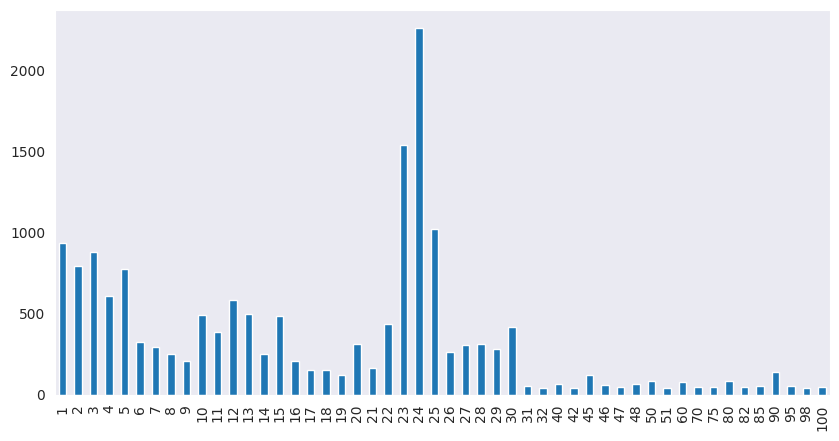

In [72]:
df_general["Duration"].value_counts().nlargest(50).sort_index().plot(kind="bar",  figsize=(10,5));

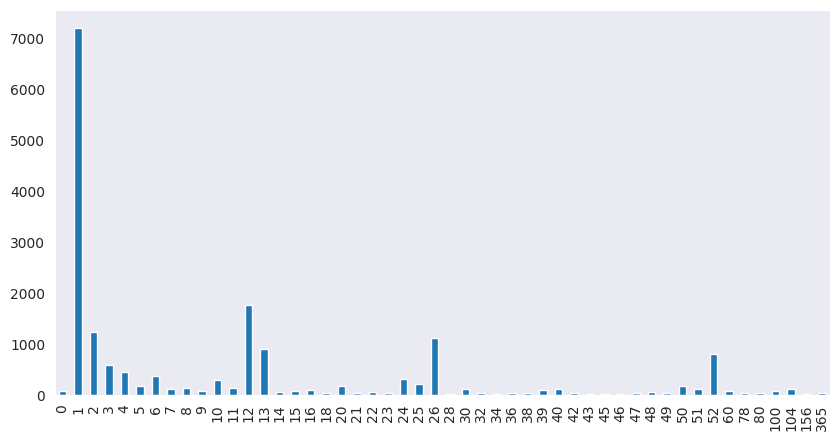

In [73]:
df_general["Episodes"].value_counts().nlargest(50).sort_index().plot(kind="bar",  figsize=(10,5));

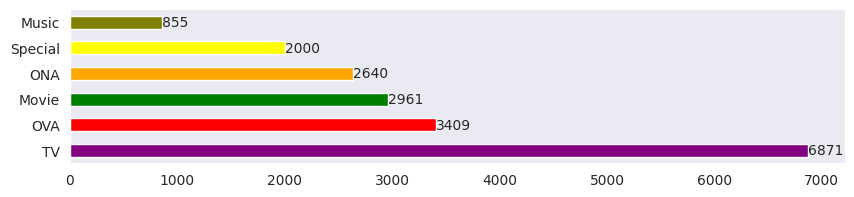

In [74]:
ax = df_general["Type"].value_counts().plot(kind="barh",
                                            figsize=(10,2),
                                            color=["purple", "red", "green", "orange", "yellow", "olive"]);
ax.bar_label(ax.containers[0]);

In [75]:
durtype = pd.DataFrame(columns=["Top 1 duration", "Amount of items (1)", "Top 2 duration",
                                "Amount of items (2)", "Top 3 duration", "Amount of items (3)"],
                       index=df_general["Type"].unique())
for types in durtype.index:
    buffer = df_general["Duration"].where(df_general["Type"] == types).dropna().value_counts().nlargest(3)
    durtype["Top 1 duration"][types] = buffer.index[0]
    durtype["Top 2 duration"][types] = buffer.index[1]
    durtype["Top 3 duration"][types] = buffer.index[2]
    durtype["Amount of items (1)"][types] = buffer.iloc[0]
    durtype["Amount of items (2)"][types] = buffer.iloc[1]
    durtype["Amount of items (3)"][types] = buffer.iloc[2]

In [76]:
epitype = pd.DataFrame(columns=["Top 1 episodes", "Amount of items (1)", "Top 2 episodes",
                                "Amount of items (2)", "Top 3 episodes", "Amount of items (3)"],
                       index=df_general["Type"].unique())
for types in epitype.index:
    buffer = df_general["Episodes"].where(df_general["Type"] == types).dropna().value_counts().nlargest(3)
    epitype["Top 1 episodes"][types] = buffer.index[0]
    epitype["Top 2 episodes"][types] = buffer.index[1]
    epitype["Top 3 episodes"][types] = buffer.index[2]
    epitype["Amount of items (1)"][types] = buffer.iloc[0]
    epitype["Amount of items (2)"][types] = buffer.iloc[1]
    epitype["Amount of items (3)"][types] = buffer.iloc[2]

In [77]:
durtype.astype("int64").style.background_gradient(cmap ='coolwarm')

In [78]:
epitype.astype("int64").style.background_gradient(cmap ='coolwarm')

## Most basic Title and Description analysys

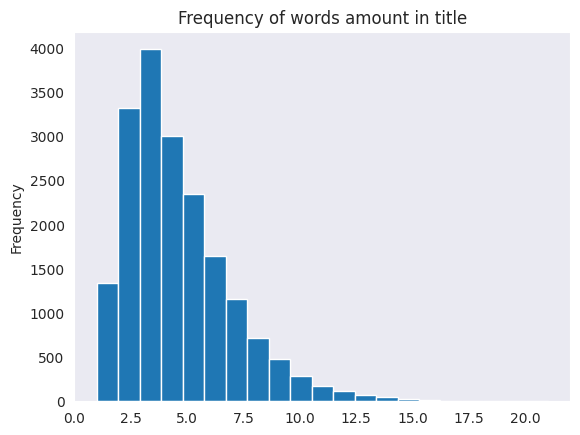

In [80]:
df_general["Title"].str.split(" ").str.len().sort_values(ascending=False).plot(kind="hist", 
                                                                               bins=21, 
                                                                               title="Frequency of words amount in title");

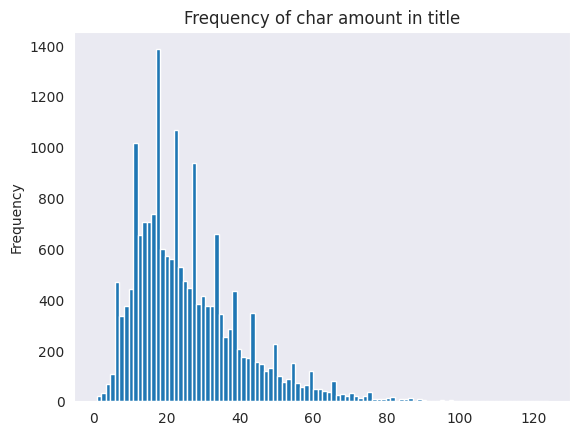

In [81]:
df_general["Title"].str.len().sort_values(ascending=False).plot(kind="hist", 
                                                                bins=100, 
                                                                title="Frequency of char amount in title");

In [155]:
Title_ORG

                                               9021
Sore Ike                                         37
Boku                                             29
Kidou Senshi Gundam                              25
Kidou Senshi                                     21
                                               ... 
Boukyaku Battery                                  1
Deep Sea                                          1
Golden Douga Gekijou Specials                     1
Mahou Shoujo Monogatari - Magica Nisioisin        1
Kimi Aishita Hitori Boku e                        1
Name: Title, Length: 7802, dtype: int64

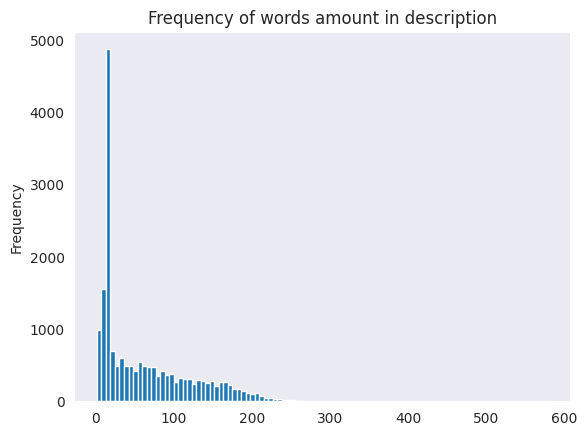

In [83]:
df_general["Description"].str.split(" ").str.len().sort_values(ascending=False).plot(kind="hist", 
                                                                                     bins=100, 
                                                                                     title="Frequency of words amount in description");

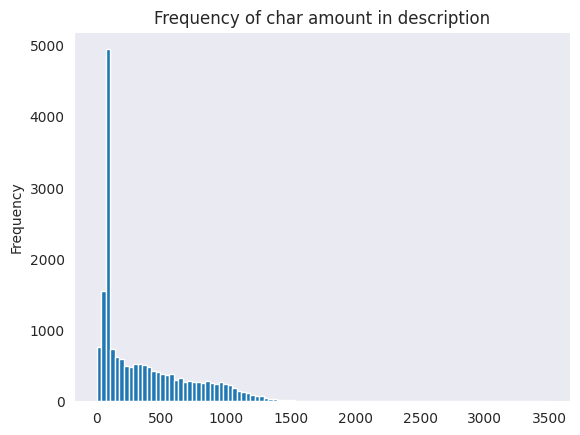

In [84]:
df_general["Description"].str.len().sort_values(ascending=False).plot(kind="hist", 
                                                                      bins=100, 
                                                                      title="Frequency of char amount in description");

## Members, Favorites, Duration and Episodes

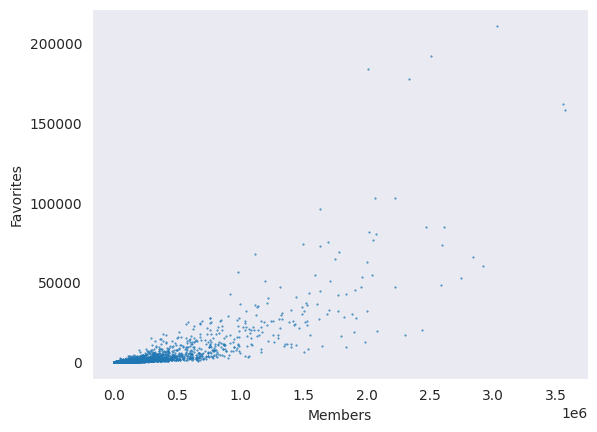

In [85]:
df_general.plot(kind="scatter", x="Members", y="Favorites", s=0.2);

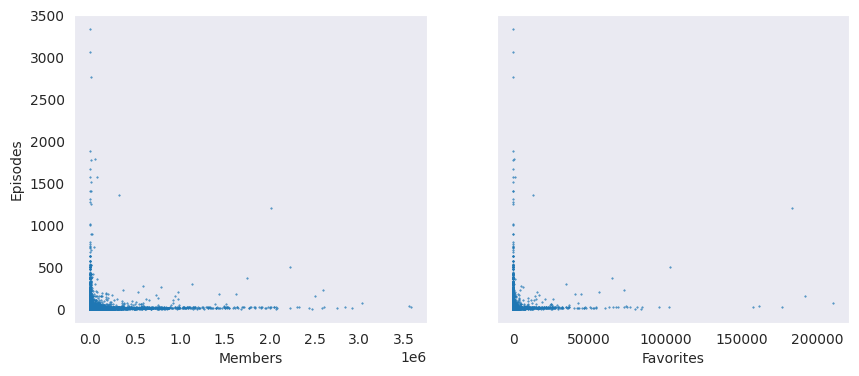

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
df_general.plot(ax=axs[0], kind="scatter", x="Members", y="Episodes", s=0.2);
df_general.plot(ax=axs[1], kind="scatter", x="Favorites", y="Episodes", s=0.2);

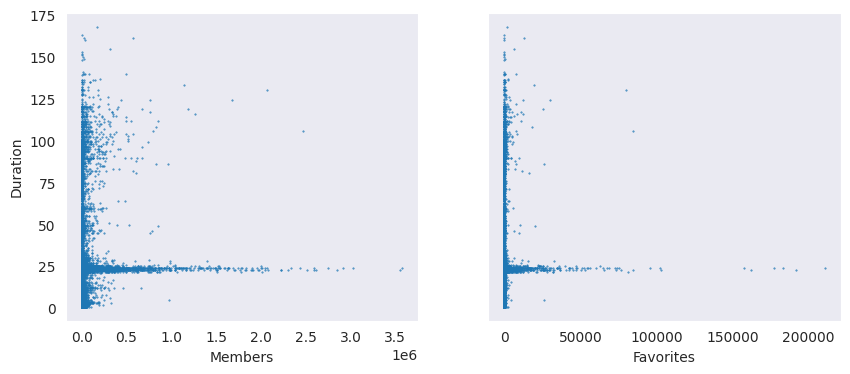

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
df_general.plot(ax=axs[0], kind="scatter", x="Members", y="Duration", s=0.2);
df_general.plot(ax=axs[1], kind="scatter", x="Favorites", y="Duration", s=0.2);

## Year when Item was released

In [88]:
df_general["Premier year"]

0        2022
1        2009
2        2022
3        2011
4        2015
         ... 
18733    2022
18734    2022
18735    2022
18736    2017
18737    2022
Name: Premier year, Length: 18736, dtype: object

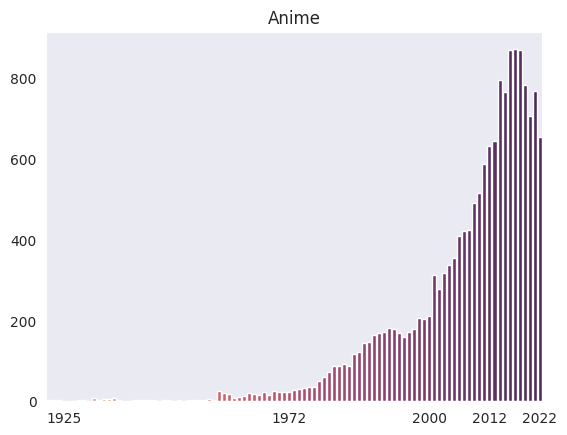

In [89]:
premier_years = df_general["Premier year"].value_counts().drop("Unknown").sort_index()
ax = sns.barplot(x=premier_years.index, y=premier_years.values, palette="flare")
#ax.set_xticks([1925, 1970, 2000, 2021]);
for index, label in enumerate(ax.get_xticklabels()):
    if label.get_text() not in ["1925", "1972", "2000", "2012", "2022"]:
        label.set_visible(False)
        ax.set(title='Anime');

In [90]:
year_demographic = pd.DataFrame(index=premier_years.index, columns=df_general["Demographics"].unique()).fillna(0)

In [91]:
for year in year_demographic.index:
    buffer = df_general["Demographics"].where(df_general["Premier year"] == year).dropna()
    for demographic in buffer:
        year_demographic[demographic][year] += 1

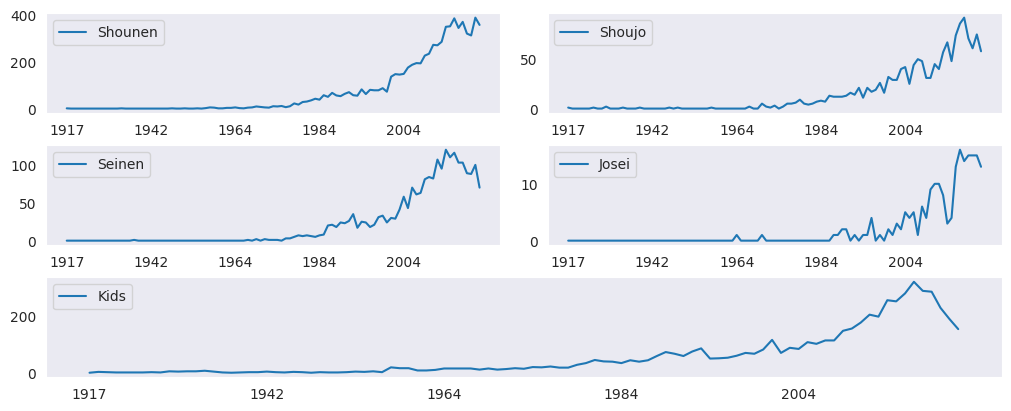

In [92]:
fig = plt.figure(figsize=(10,4), constrained_layout=True)
gs = mpl.gridspec.GridSpec(3,2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])
axises = [ax1, ax2, ax3, ax4, ax5, ax6]
fig.subplots_adjust(hspace=0.5)

for axis in range(5):
    year_demographic.T[axis:axis+1].T.plot(ax=axises[axis]);

In [93]:
year_source = pd.DataFrame(index=premier_years.index, columns=df_general["Source"].unique()).fillna(0)

In [94]:
for year in year_source.index:
    buffer = df_general["Source"].where(df_general["Premier year"] == year).dropna()
    for source in buffer:
        year_source[source][year] += 1

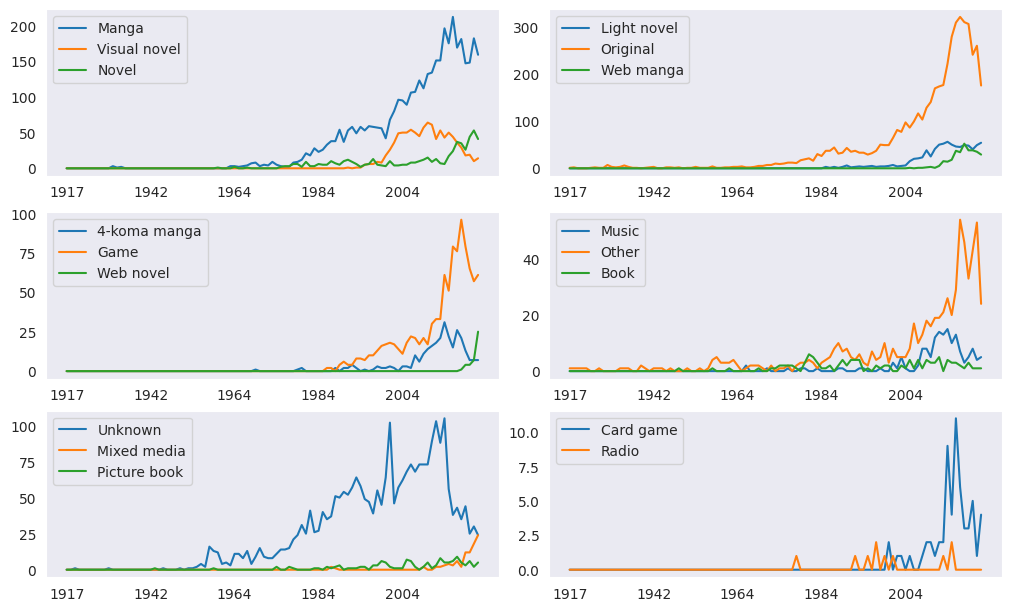

In [95]:
fig = plt.figure(figsize=(10,6), constrained_layout=True)
gs = mpl.gridspec.GridSpec(3,2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
axises = [ax1, ax2, ax3, ax4, ax5, ax6]
fig.subplots_adjust(hspace=0.5)

for axis in range(6):
    year_source.T[(axis * 3):(axis * 3)+3].T.plot(ax=axises[axis]);

In [96]:
year_rating = pd.DataFrame(index=premier_years.index, columns=df_general["Rating"].unique()).fillna(0)

In [97]:
for year in year_rating.index:
    buffer = df_general["Rating"].where(df_general["Premier year"] == year).dropna()
    for rating in buffer:
        year_rating[rating][year] += 1

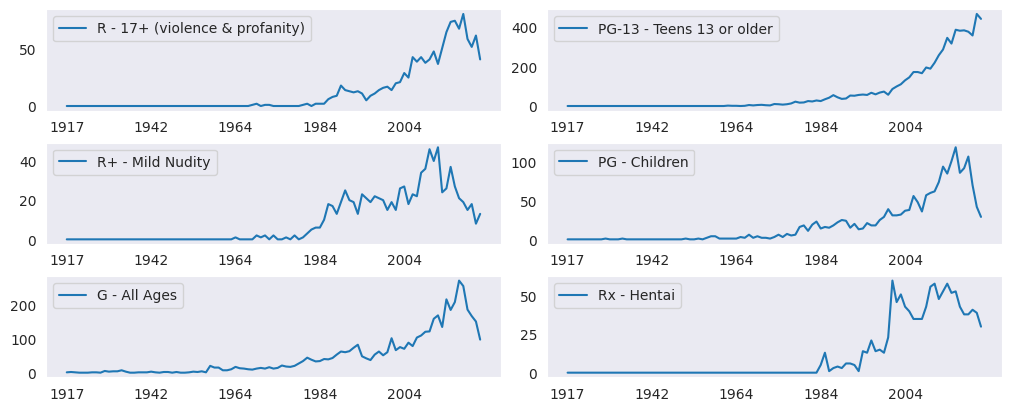

In [98]:
fig = plt.figure(figsize=(10,4), constrained_layout=True)
gs = mpl.gridspec.GridSpec(3,2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
axises = [ax1, ax2, ax3, ax4, ax5, ax6]
fig.subplots_adjust(hspace=0.5)

for axis in range(6):
    year_rating.T[axis:axis+1].T.plot(ax=axises[axis]);

In [99]:
year_theme = pd.DataFrame(index = premier_years.index, columns=themes.index).fillna(0)

In [100]:
for year in year_theme.index:
    buffer = df_general["Themes"].where(df_general["Premier year"] == year).dropna().str.split(", ")
    for theme in buffer:
        for item in theme: 
            year_theme[item][year] += 1

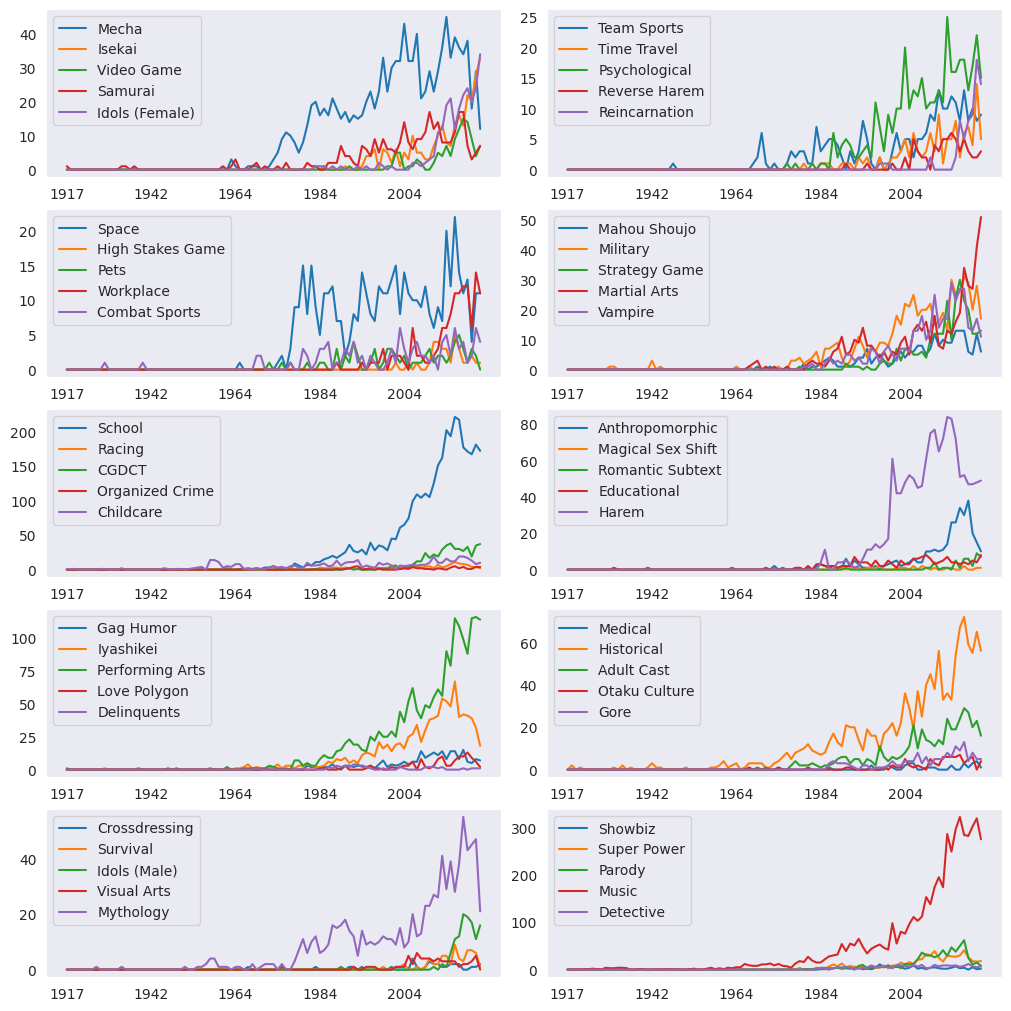

In [101]:
fig = plt.figure(figsize=(10,10), constrained_layout=True)
gs = mpl.gridspec.GridSpec(5,2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[3, 0])
ax8 = fig.add_subplot(gs[3, 1])
ax9 = fig.add_subplot(gs[4, 0])
ax10 = fig.add_subplot(gs[4, 1])
axises = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
fig.subplots_adjust(hspace=0.5)

for axis in range(10):
    year_theme.T[axis * 5:(axis * 5) + 5].T.plot(ax=axises[axis]);

In [102]:
year_genre = pd.DataFrame(index = premier_years.index, columns=genres.index).fillna(0)

In [103]:
for year in year_genre.index:
    buffer = df_general["Genres"].where(df_general["Premier year"] == year).dropna().str.split(", ")
    for genre in buffer:
        for item in genre: 
            year_genre[item][year] += 1

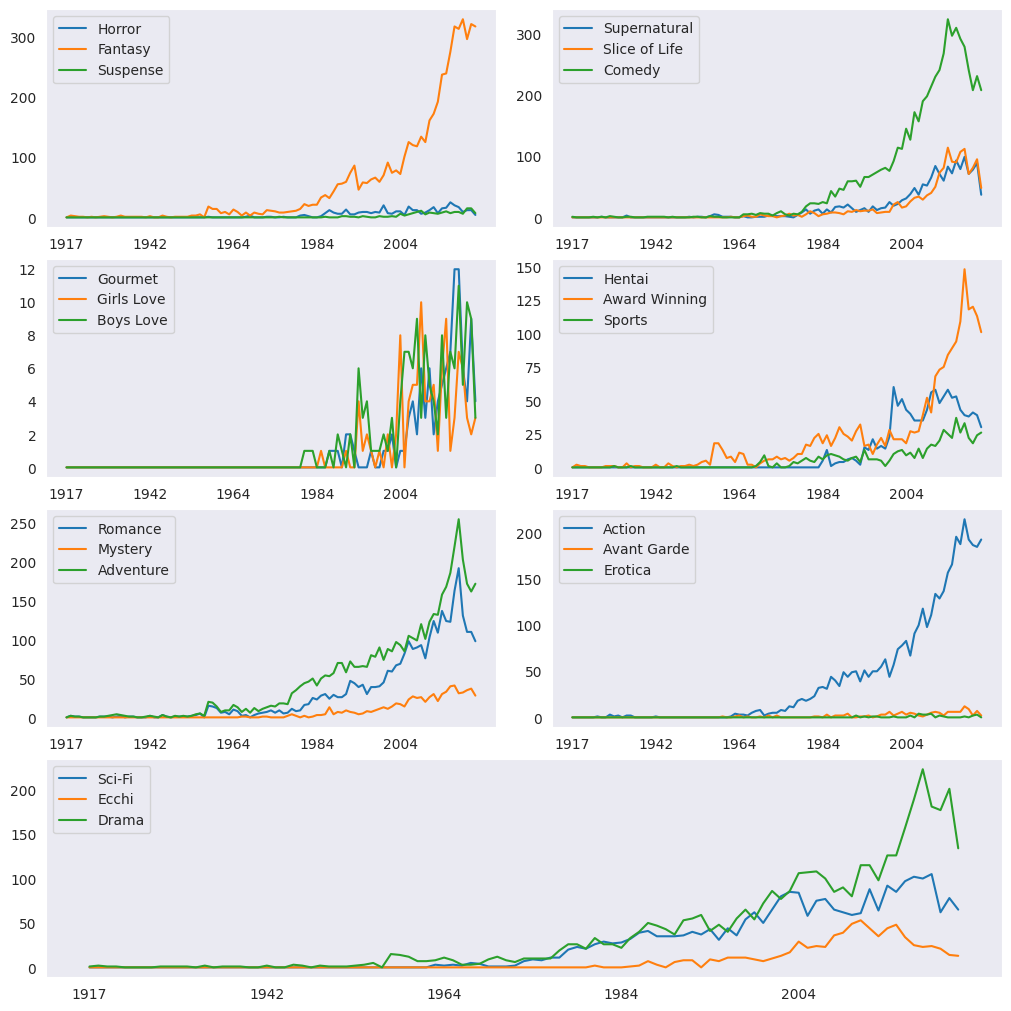

In [104]:
fig = plt.figure(figsize=(10,10), constrained_layout=True)
gs = mpl.gridspec.GridSpec(4,2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[3, :])
axises = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
fig.subplots_adjust(hspace=0.5)

for axis in range(7):
    year_genre.T[axis * 3:(axis * 3) + 3].T.plot(ax=axises[axis]);

## Season of release

In [105]:
season_plot = pd.DataFrame(columns=df_general["Premier season"].unique()[:-1], 
                           index=df_general["Premier year"].value_counts().drop(["2022", "Unknown"]).\
                           nlargest(12).index[1:]).sort_index(ascending=False).T.\
                           apply(lambda x: df_general["Premier season"].\
                           where(df_general["Premier year"] == x.name).value_counts().drop("Unknown")).T

In [106]:
season_genre = pd.DataFrame(index=season_plot.columns, columns=genres.index).fillna(0)

In [107]:
for season in season_genre.index:
    buffer = df_general["Genres"].where(df_general["Premier season"] == season).dropna().str.split(", ")
    for genre in buffer:
        for item in genre: 
            season_genre[item][season] += 1

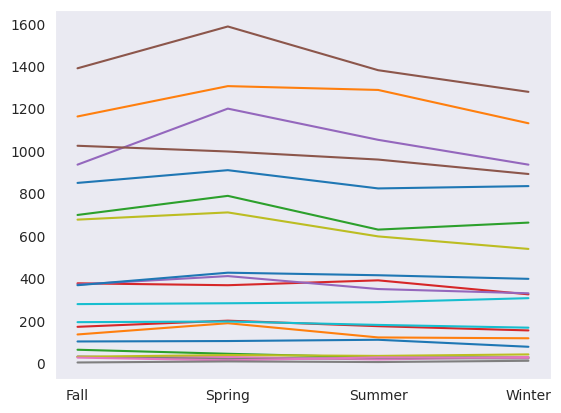

In [108]:
season_genre.plot(legend=False);

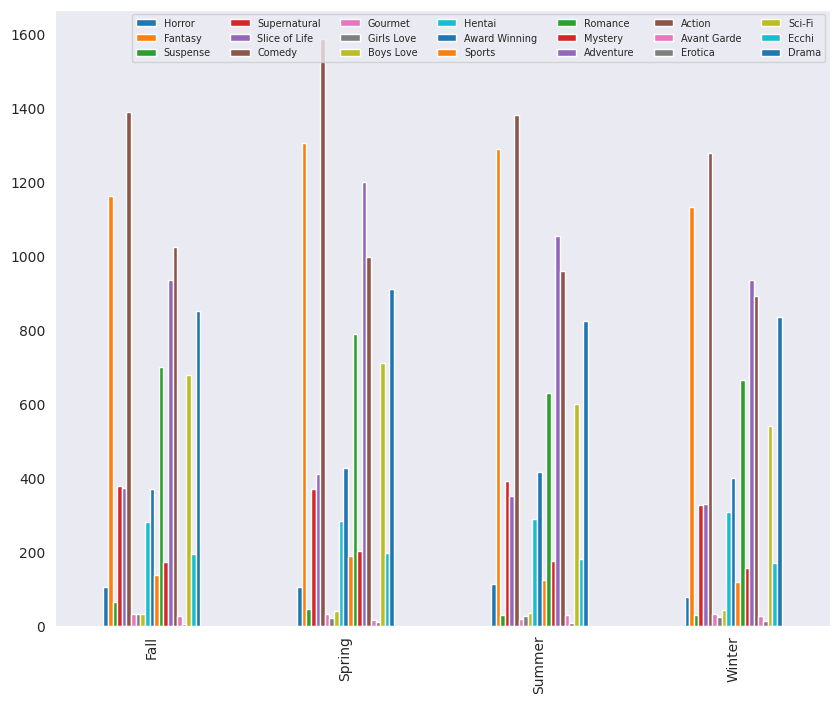

In [109]:
ax = season_genre.plot(kind="bar", figsize=(10, 8));
ax.legend(ncol=7, prop={'size': 7});

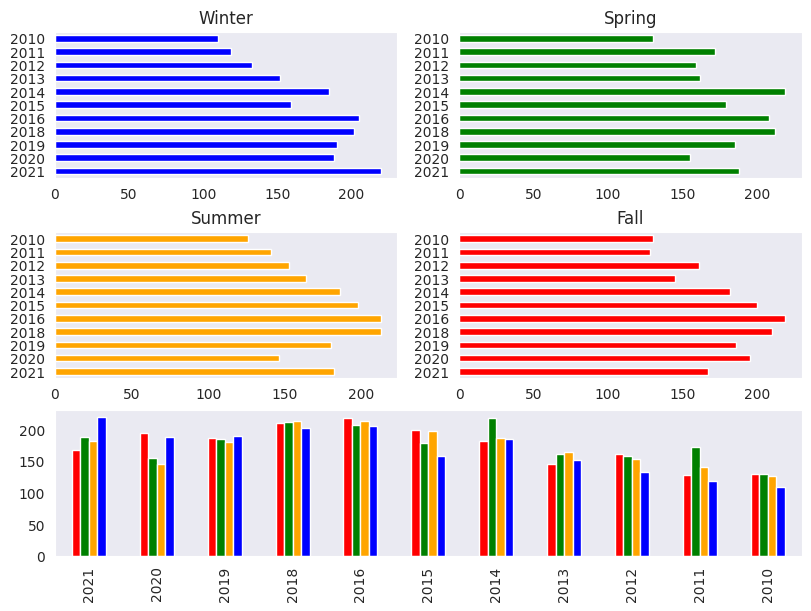

In [110]:
fig = plt.figure(figsize=(8,6), constrained_layout=True)
gs = mpl.gridspec.GridSpec(3,2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])
fig.subplots_adjust(hspace=0.5)

colors=["red", "green", "orange", "blue"]
season_plot["Fall"].plot(ax=ax4, kind="barh", color=colors[0], title="Fall")
season_plot["Spring"].plot(ax=ax2, kind="barh", color=colors[1], title="Spring")
season_plot["Summer"].plot(ax=ax3, kind="barh", color=colors[2], title="Summer")
season_plot["Winter"].plot(ax=ax1, kind="barh", color=colors[3], title="Winter")
season_plot.plot(ax=ax5, kind="bar", color=colors, legend=False);

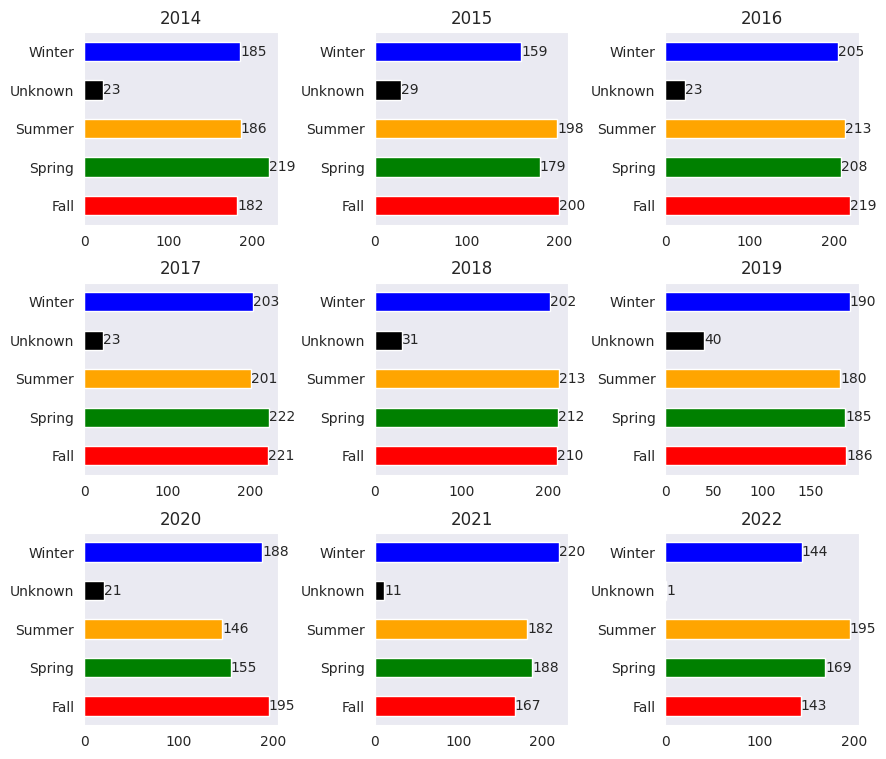

In [111]:
fig, axs = plt.subplots(3, 3, figsize=(10,9))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.5)
for axis, year in enumerate(df_general["Premier year"].value_counts().nlargest(10)[1:].sort_index().index):
    df_general["Premier season"].where(df_general["Premier year"] == year).value_counts().\
    sort_index().plot(ax=axs[axis], kind="barh", title=year, color=["red", "green", "orange", "black", "blue"])
    axs[axis].bar_label(axs[axis].containers[0]);

## Month of release

In [112]:
df_general["Premier month"] = df_general["Aired"].str.split(" ").str[0]
month = ["Jan", "Feb", "Apr", "Mar", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month.reverse()
df_general["Premier month"] = df_general["Premier month"].apply(lambda x: "Unknown" if x not in month else x)
months = df_general["Premier month"].value_counts(sort=False).drop("Unknown")
months.index = months.index.astype("category").set_categories(month)
months = months.sort_index()

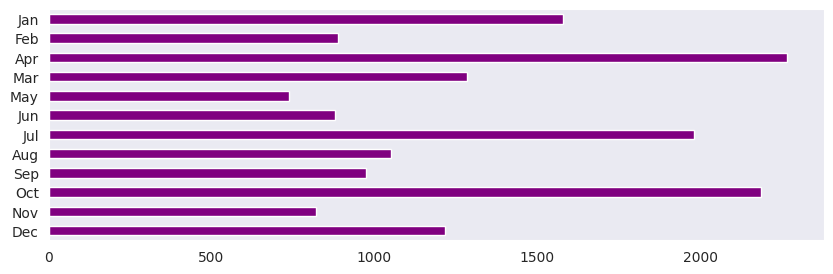

In [113]:
months.plot(kind="barh", figsize=(10,3), color="purple");

In [114]:
month_genre = pd.DataFrame(index=months.index, columns=genres.index).fillna(0)

In [115]:
for month in months.index:
    buffer = df_general["Genres"].where(df_general["Premier month"] == month).dropna().str.split(", ")
    for genre in buffer:
        for item in genre:
            month_genre[item][month] += 1

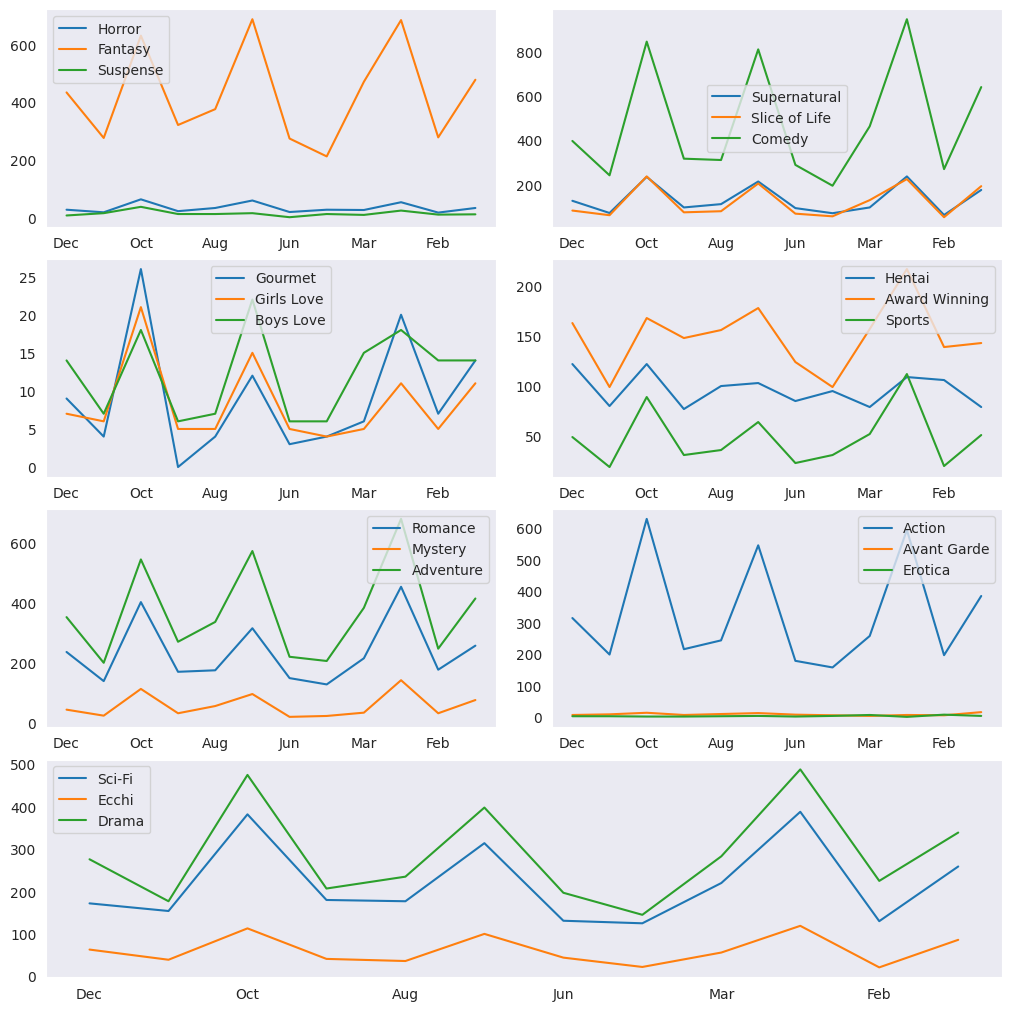

In [116]:
fig = plt.figure(figsize=(10,10), constrained_layout=True)
gs = mpl.gridspec.GridSpec(4,2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[3, :])
axises = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
fig.subplots_adjust(hspace=0.5)

for axis in range(7):
    month_genre.T[axis * 3:(axis * 3) + 3].T.plot(ax=axises[axis]);

## Day of release and end

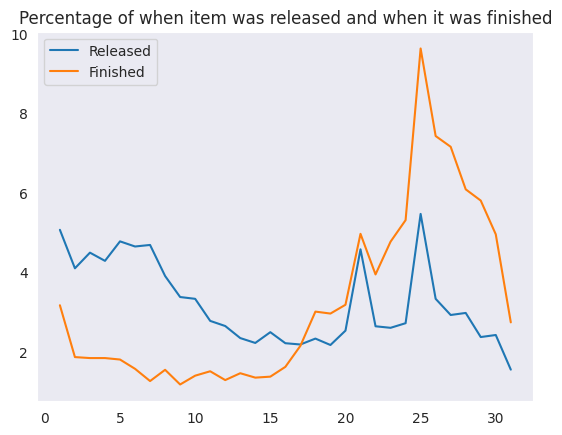

In [117]:
shiet = pd.DataFrame(columns=["Released", "Finished"], index=[i for i in range(1, 32)]).fillna(0)
for item in df_general["Aired"]:
    days = []
    for number in re.findall("[0-9]+", item):
        if len(number) < 4:
            days.append(int(number))
    for thing2, thing1 in zip(days, shiet.columns[:len(days)]):
        shiet[thing1][thing2] += 1
shiet = shiet / shiet.sum() * 100
shiet.plot(title="Percentage of when item was released and when it was finished");

In [118]:
week_days = ["Mondays", "Tuesdays", "Wednesdays", "Thursdays", "Fridays", "Saturdays", "Sundays", "Unknown", "One", "Not"]
# Morning: 6:01 - 12:00
# Afternoon: 12:01 - 18:00
# Evening: 18:01 - 00:00
# Night: 00:01 - 6:00
time_of_the_day = ["Night", "Morning", "Afternoon", "Evening"]

In [119]:
broadcast_day = pd.Series(index=week_days).fillna(0)

In [120]:
for item in df_general["Broadcast"].str.split(" ").str[0]:
    broadcast_day[item] += 1

In [121]:
broadcast_day["One Time Release"] = broadcast_day["One"]
broadcast_day.drop("One", inplace=True)
broadcast_day["Unknown"] += broadcast_day["Not"]
broadcast_day.drop("Not", inplace=True)

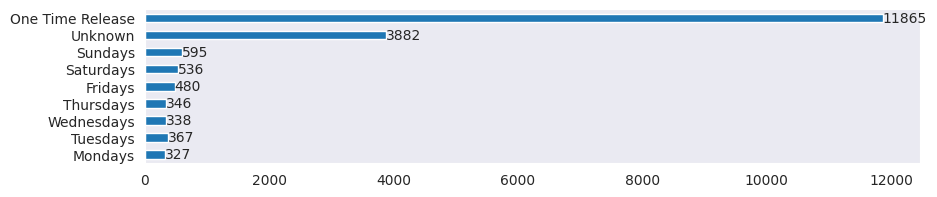

In [122]:
ax = broadcast_day.plot(kind="barh", figsize=(10,2));
ax.bar_label(ax.containers[0]);

In [123]:
broadcast_week = broadcast_day.drop(["One Time Release", "Unknown"])

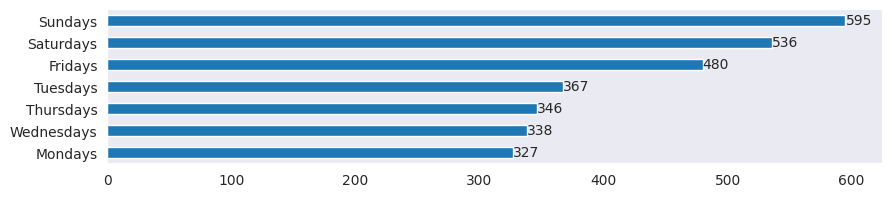

In [124]:
ax = broadcast_week.sort_values().plot(kind="barh", figsize=(10, 2))
ax.bar_label(ax.containers[0]);

## Time of broadcast

In [125]:
broadcast_time = pd.Series(index=time_of_the_day).fillna(0)

In [126]:
for index, value in zip(df_general["Broadcast"].str.split(" ")\
                       .apply(lambda x: x[2] if x[-1] == "(JST)" else np.NaN)\
                       .dropna().index,
                        df_general["Broadcast"].str.split(" ")\
                       .apply(lambda x: x[2] if x[-1] == "(JST)" else np.NaN)\
                       .dropna().str.split(":")):
    time = int(value[0]) * 60 + int(value[1])
    time_index = np.NaN
    if time <= 6*60 and time >= 1:
        time_index = 0
    elif time <= 12*60 and time >= 6*60+1:
        time_index = 1
    elif time <= 18*60 and time >= 12*60+1:
        time_index = 2
    else:
        time_index = 3
    broadcast_time[time_of_the_day[time_index]] += 1

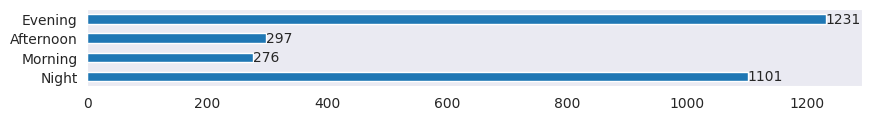

In [127]:
ax = broadcast_time.plot(kind="barh", figsize=(10,1));
ax.bar_label(ax.containers[0]);

# Load data about reviews

In [397]:
df = pd.read_json("Anime_reviews.json")
df.head()

Title  review_count  \
0            Bleach: Sennen Kessen-hen            20   
1                    Mob Psycho 100 II            20   
2  Gintama.: Shirogane no Tamashii-hen            17   
3                   Kingdom 3rd Season            20   
4        Kimetsu no Yaiba: Yuukaku-hen            20   

                                            review 1  \
0  ["Bleach has finally made its way into the mid...   
1  ["I wanted to make something kind." - ONE [Aut...   
2  [I could say a lot about this franchise, but I...   
3  [ --The review contains spoilers--   This is m...   
4  [Contains some mild spoilers.  "Demon Slayer i...   

                                            review 2  \
0  [BLEACH has finally made its great return to t...   
1  [(Slight spoiler warning in the third paragrap...   
2  [Reading the other reviews posted here, and gu...   
3  [Kingdom Is OP From the plot to the action, it...   
4  [***THIS REVIEW MIGHT CONTAIN SPOILERS, AND MA...   

                                            review 3  
0  [Tite Kubo has seemingly not developed his cha...  
1  [What makes a show good? Is it the story’s abi...  
2  [Gintama is an anime franchise with several se...  
3  [KINGDOM is back as a 3rd season, with its 'SP...  
4  [*out-of-context spoilers*  People always say ...

## Cleaning data about review by concantenating all reviews to one column and visualyze some data about reviews

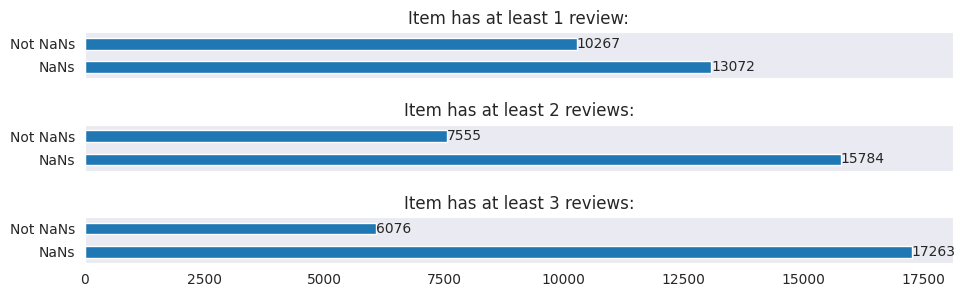

In [398]:
fig, axs = plt.subplots(3, 1, figsize=(11.2, 3), sharex = True)
fig.subplots_adjust(hspace=1)
for i in range(1, 4):
    # df[f"review {i}"] = df[f"review {i}"].apply(lambda x: x[0] if isinstance(x, list) else x)
    if i >= 2:
        s = "s"
    else:
        s = ""
    df[f"review {i}"].isnull().apply(lambda x: "NaNs" if x is True else "Not NaNs").value_counts().plot(ax=axs[i-1], kind="barh", title=f"Item has at least {i} review{s}:");
    axs[i-1].bar_label(axs[i-1].containers[0]);
    df[f"review {i}"] = df[f"review {i}"].fillna("")

In [ ]:
df["Reviews"] = (df["review 1"] + "\n\n" + df["review 2"] + "\n\n" + df["review 3"]).str.strip()
df.drop([f"review {i}" for i in range(1, 4)], axis="columns", inplace=True)

In [401]:
df["Reviews"] = np.NaN
df["Reviews"] = df["Reviews"].apply(lambda x: [])
for index in df.index:
    for i in range(1, 4):
        df["Reviews"][index] += df[f"review {i}"][index]

In [418]:
df["Words"] = (df["Reviews"].str[0].str.split(" ").str.len() + df["Reviews"].str[1].str.split(" ").str.len() + df["Reviews"].str[2].str.split(" ").str.len()).fillna(0)

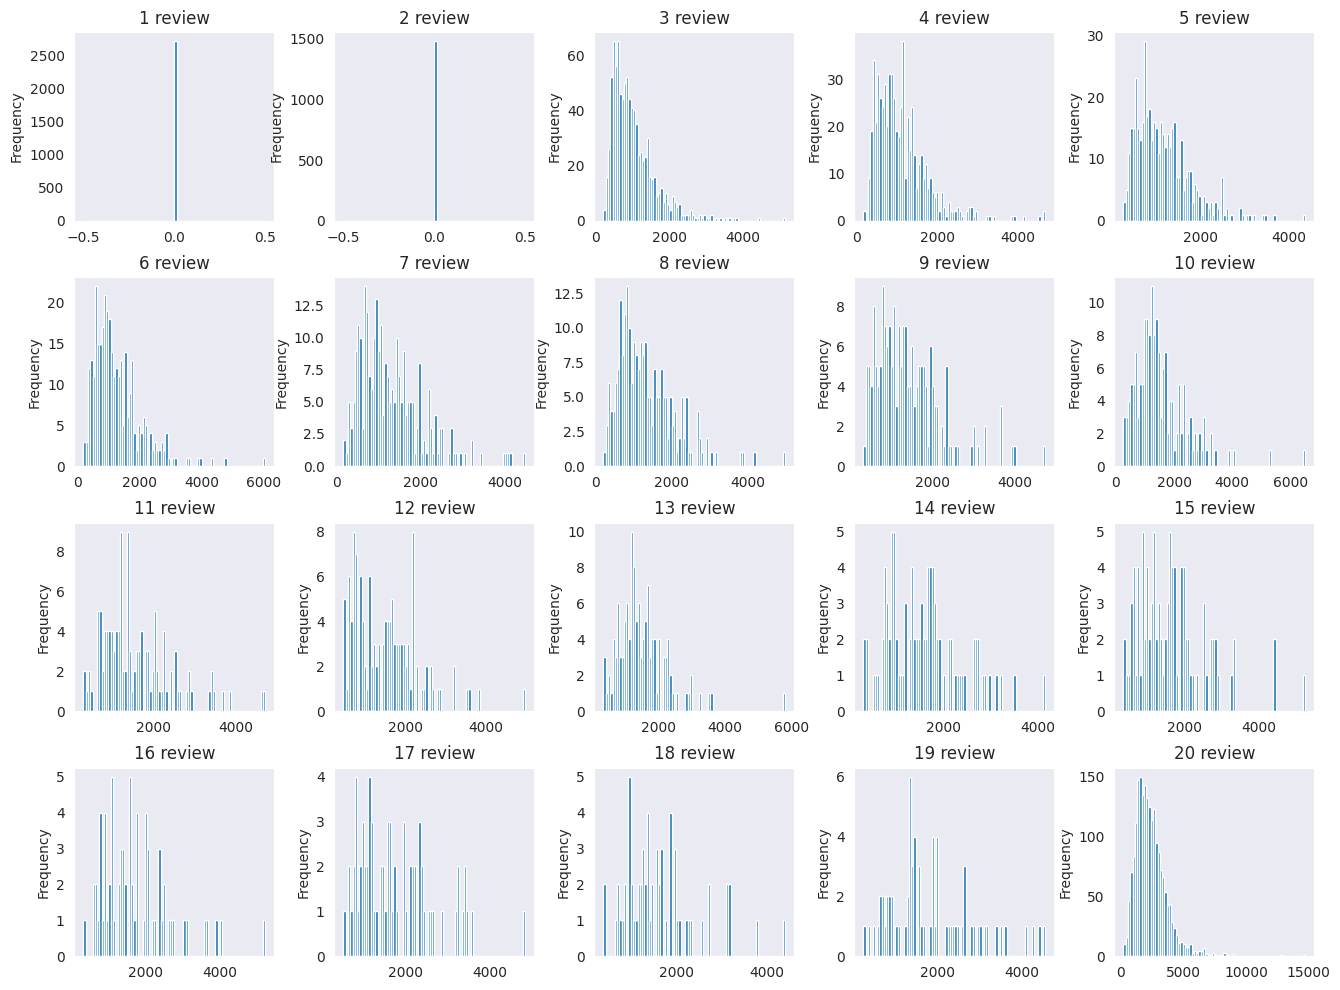

In [420]:
fig, axs = plt.subplots(4, 5, figsize=(16, 12))
axs = axs.ravel();
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
for i in range(1, 21):
    df["Words"].where(df["review_count"] == i).dropna().plot(ax=axs[i-1], kind="hist", bins=80, title=f"{i} review")

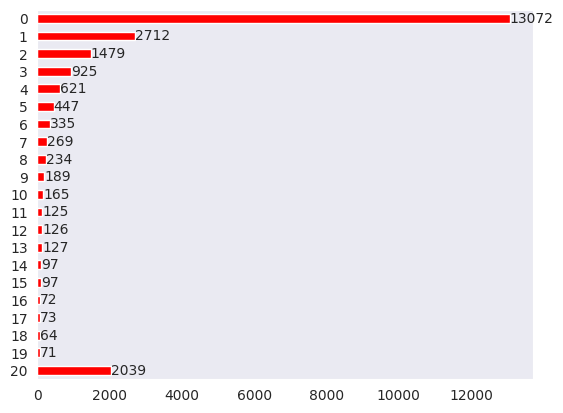

In [422]:
ax = df["review_count"].value_counts().sort_index(ascending=False).plot(kind="barh", color="red");
ax.bar_label(ax.containers[0]);

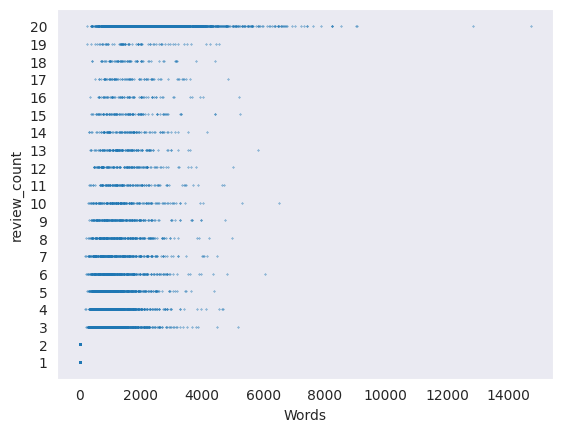

In [423]:
df[["Words", "review_count"]].where(df["review_count"] > 0).dropna().plot(kind="scatter", x="Words", y="review_count", s=0.1, yticks=[i for i in range(1,21)]);

In [134]:
buffer = df_general["Title"].copy()
for index, item in zip(buffer.index, buffer):
    for sub_item in item.split(" "):
        if len(re.findall("[^A-z]", sub_item)) == 0:
            buffer.drop(index, inplace=True)
            break

In [135]:
symbols = set()
for item in buffer.str.findall("[^A-z]"):
    for sub_item in item:
        symbols.add(sub_item)
symbols = pd.Series(index=symbols)
symbols.drop(" ", inplace=True)

In [136]:
for item in symbols.index:
    symbols[item] = len(df_general["Title"].where(df_general["Title"].str.find(item) > -1).dropna())

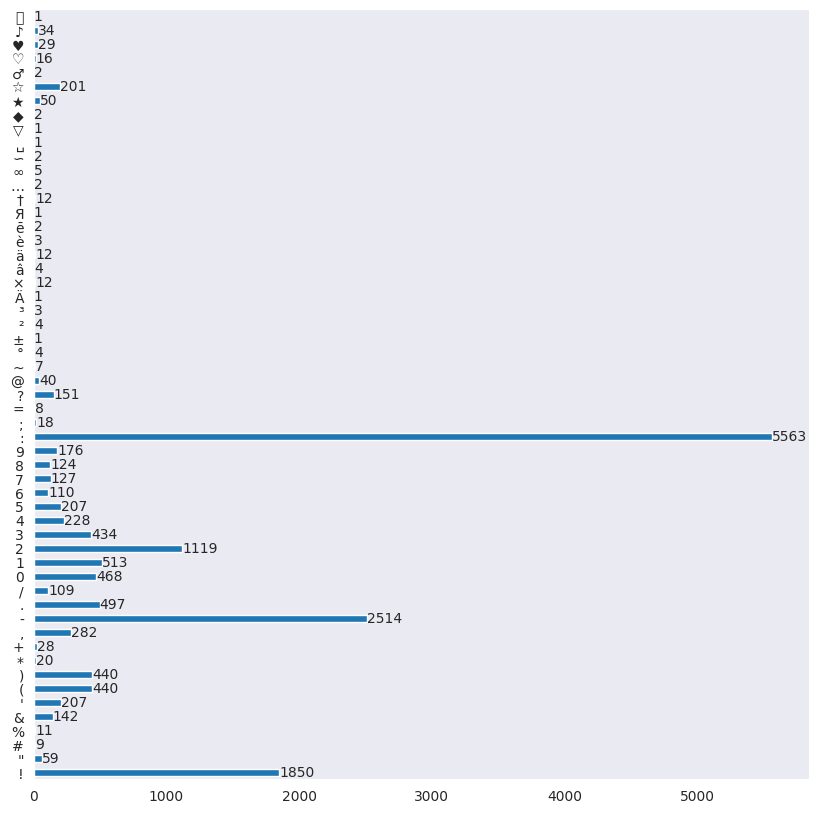

In [137]:
ax = symbols.sort_index().plot(kind="barh", figsize=(10, 10));
ax.bar_label(ax.containers[0]);

In [151]:
from laserembeddings import Laser

path_to_bpe_codes = "Laser_embd_down/93langs.fcodes"
path_to_bpe_vocab = "Laser_embd_down/93langs.fvocab"
path_to_encoder = "Laser_embd_down/bilstm.93langs.2018-12-26.pt"
laser = Laser(path_to_bpe_codes, path_to_bpe_vocab, path_to_encoder)

In [152]:
embeddings = laser.embed_sentences(["Hello", "Hi", "Привіт", "Hallo"], lang="en")

In [153]:
pd.DataFrame(embeddings, index=["Hello", "Hi", "Привіт", "Hallo"])

0         1         2         3         4         5         6     \
Hello   0.003820  0.000653 -0.002475 -0.001375 -0.014447 -0.000265  0.000037   
Hi      0.001694  0.001516  0.000879 -0.000412 -0.009121  0.000968 -0.000504   
Привіт  0.000738  0.000958 -0.000294 -0.000047 -0.000795  0.000479 -0.000168   
Hallo   0.002228  0.000941 -0.001594 -0.001267 -0.011408  0.000271 -0.000376   

            7         8         9     ...      1014      1015      1016  \
Hello   0.011091  0.000122 -0.000809  ... -0.004716  0.000124 -0.000355   
Hi      0.015338 -0.002148 -0.000231  ... -0.000311 -0.000955 -0.000801   
Привіт  0.006805 -0.000557 -0.000058  ...  0.000633  0.000209 -0.000006   
Hallo   0.007398 -0.000041 -0.000384  ... -0.001952  0.000348 -0.000086   

            1017      1018      1019      1020      1021      1022      1023  
Hello  -0.002557 -0.000931  0.000139 -0.001598  0.003205 -0.003695 -0.009484  
Hi     -0.001924 -0.001210  0.000487 -0.002644  0.000188 -0.004180 -0.009530  
Привіт -0.001277 -0.000375 -0.000247 -0.000622 -0.001031 -0.003916 -0.003939  
Hallo  -0.002093 -0.000801 -0.000171 -0.001447 -0.001583 -0.005185 -0.005903  

[4 rows x 1024 columns]

In [156]:
pd.DataFrame(embeddings, index=["Hello", "Hi", "Привіт", "Hallo"]).T.corr()

Hello        Hi    Привіт     Hallo
Hello   1.000000  0.923036  0.931176  0.979233
Hi      0.923036  1.000000  0.926394  0.903395
Привіт  0.931176  0.926394  1.000000  0.939959
Hallo   0.979233  0.903395  0.939959  1.000000

In [357]:
characters = pd.read_json("Characters_refactor.json")
characters["Name"] = characters["Name"].str.strip()
#characters = characters.set_index("Name")
characters.drop(["Manga", "Member favorites"], axis="columns", inplace=True)
characters.drop(characters.where(characters["Anime"].str.len() == 0).dropna().index, inplace=True)
#characters["Anime"] = characters["Anime"].str.strip("[").str.strip("]").apply(lambda x: np.NaN if x == "" else x)
#characters["Description"] = characters["Description"].str.replace("No biography written.", "")
#characters["Actors"] = characters["Actors"].str.replace("'", "").str.replace("[", "").str.replace("]", "").apply(lambda x: "No actors" if x == "" else x)
#characters["Actors"] = characters["Actors"].str.split(", ")
#characters.dropna(inplace=True)

In [197]:
df_general.set_index("Title", inplace=True)

In [381]:
for column in ["Characters", "Character Description", "Actors"]:
    df_general[column] = np.NaN
    df_general[column] = df_general[column].apply(lambda x: [])
for anime, character, description, actors, favorites in zip(characters["Anime"],
                                                            characters["Name"],
                                                            characters["Description"],
                                                            characters["Actors"]):
    for item in anime:
        if item in df_general.index:
            df_general["Characters"][item].append(character)
            df_general["Character Description"][item].append(description)
            for actor in actors:
                df_general["Actors"][item].append(actor)
        else:
            pass

In [429]:
df_general["Reviews"] = np.NaN
for index, reviews in zip(df["Title"], df["Reviews"]):
    if index in df_general.index:
        df_general["Reviews"][index] = reviews

In [386]:
for index, item in zip(df_general.index, df_general["Characters"]):
    if len(item) == 0:
        for column in ["Characters", "Actors", "Character Description"]:
            df_general[column][index] = "No info"

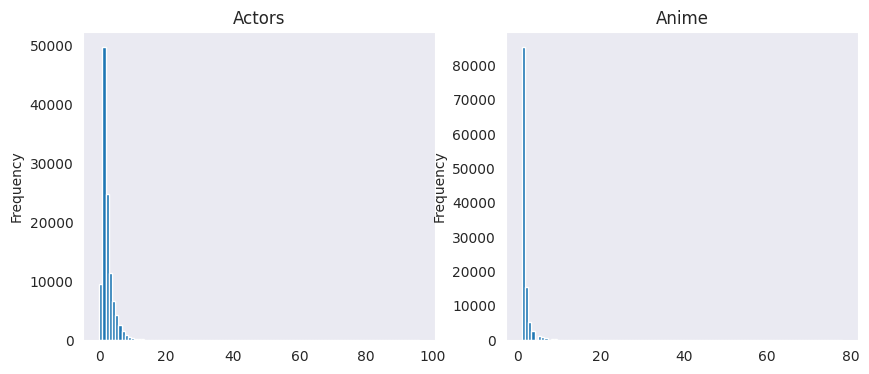

In [442]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
characters["Actors"].str.len().plot(ax=axs[0], kind="hist", bins=100, title="Actors");
characters["Anime"].str.len().plot(ax=axs[1], kind="hist", bins=100, title="Anime");

# SUMMARY

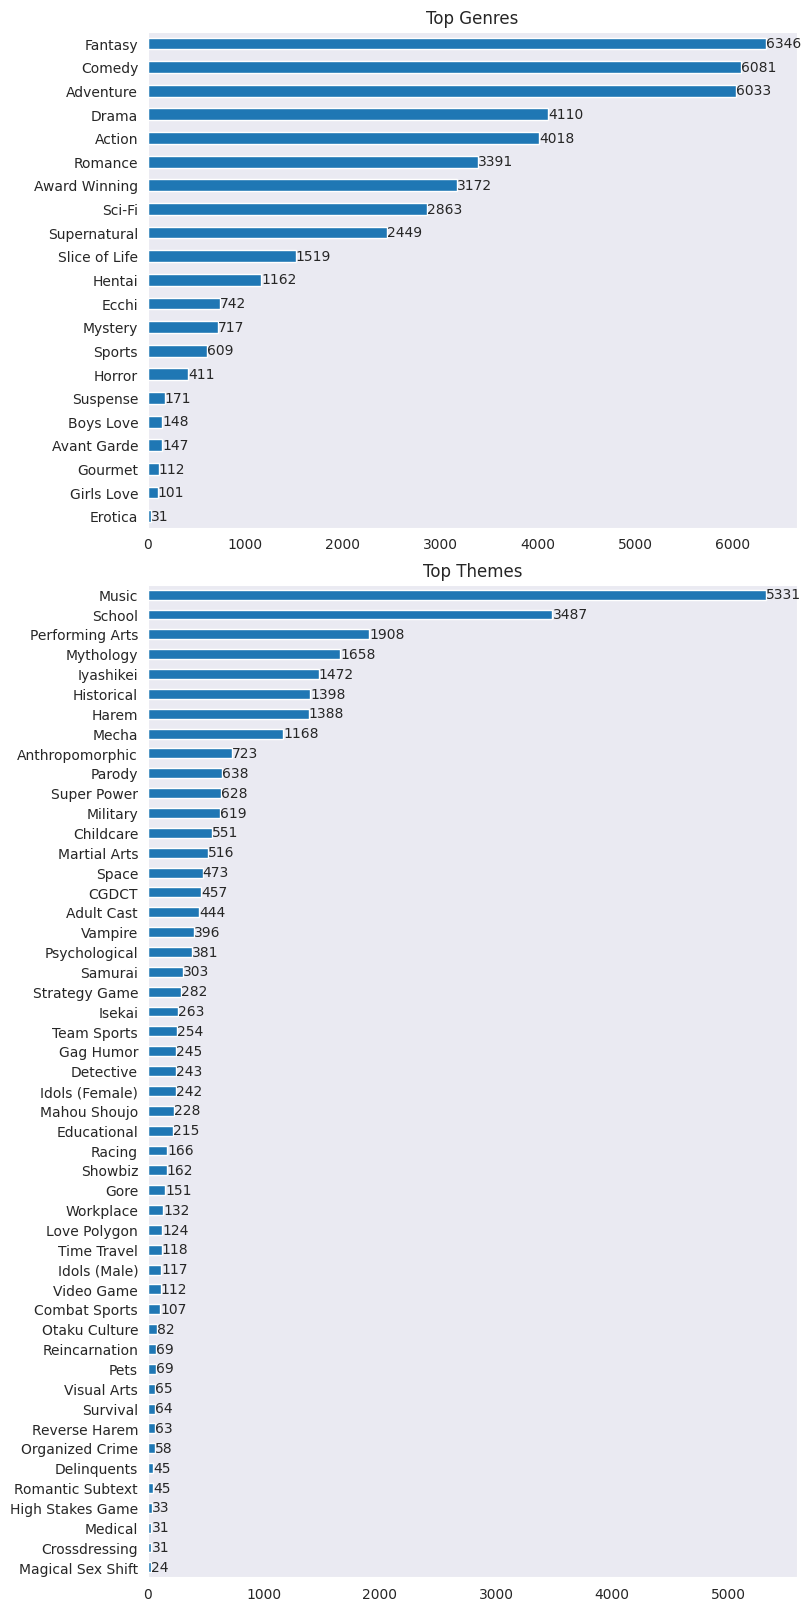

In [144]:
fig = plt.figure(figsize=(8,16), constrained_layout=True)
gs = mpl.gridspec.GridSpec(3, 1, figure=fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1:])

genres.sort_values().plot(ax=ax1, kind="barh", title="Top Genres");
ax1.bar_label(ax1.containers[0]);
themes.sort_values().plot(ax=ax2, kind="barh", title="Top Themes");
ax2.bar_label(ax2.containers[0]);

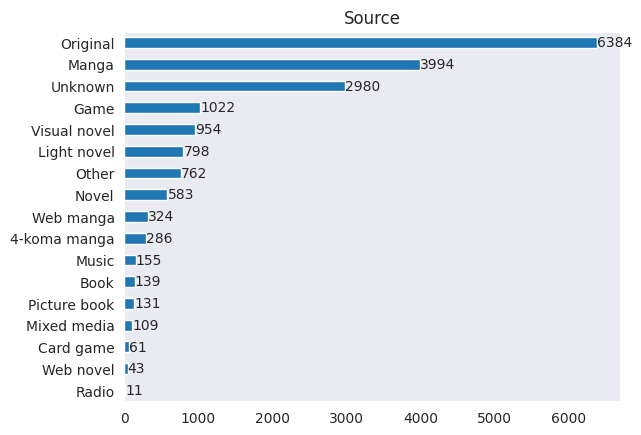

In [145]:
ax = df_general["Source"].value_counts().sort_values().plot(kind="barh", title="Source");
ax.bar_label(ax.containers[0]);

In [146]:
genre_theme.T.style.background_gradient(cmap ='coolwarm')

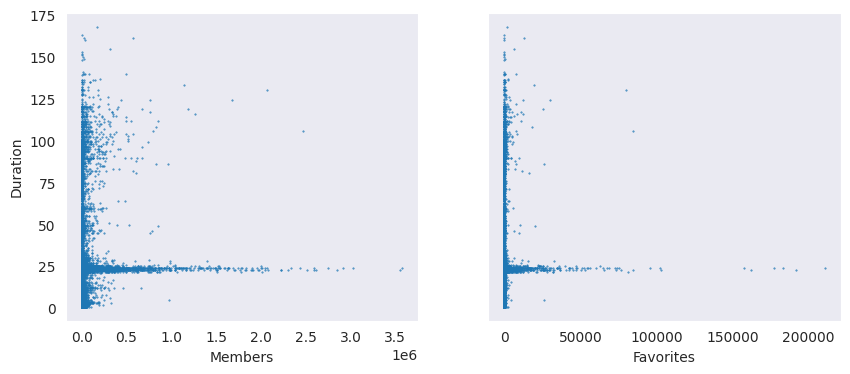

In [147]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
df_general.plot(ax=axs[0], kind="scatter", x="Members", y="Duration", s=0.2);
df_general.plot(ax=axs[1], kind="scatter", x="Favorites", y="Duration", s=0.2);

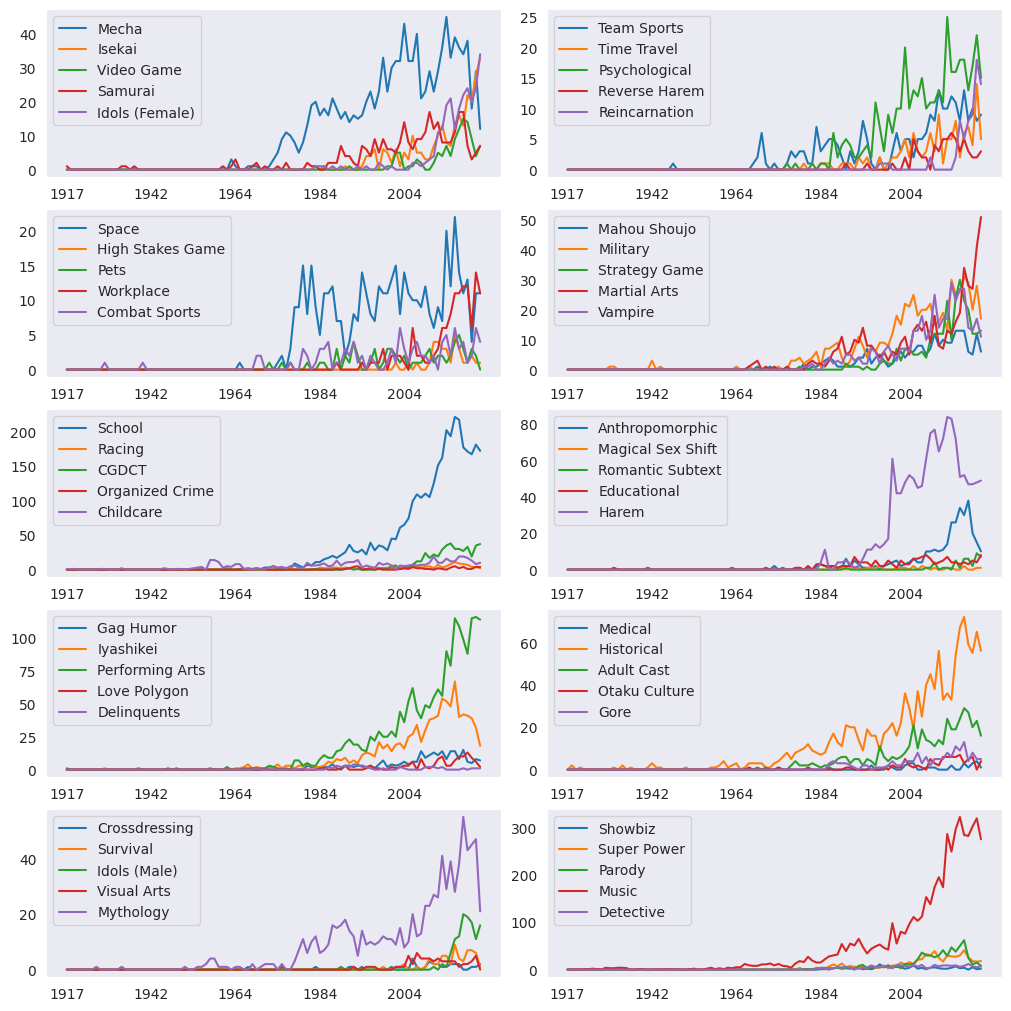

In [148]:
fig = plt.figure(figsize=(10,10), constrained_layout=True)
gs = mpl.gridspec.GridSpec(5,2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[3, 0])
ax8 = fig.add_subplot(gs[3, 1])
ax9 = fig.add_subplot(gs[4, 0])
ax10 = fig.add_subplot(gs[4, 1])
axises = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
fig.subplots_adjust(hspace=0.5)

for axis in range(10):
    year_theme.T[axis * 5:(axis * 5) + 5].T.plot(ax=axises[axis]);

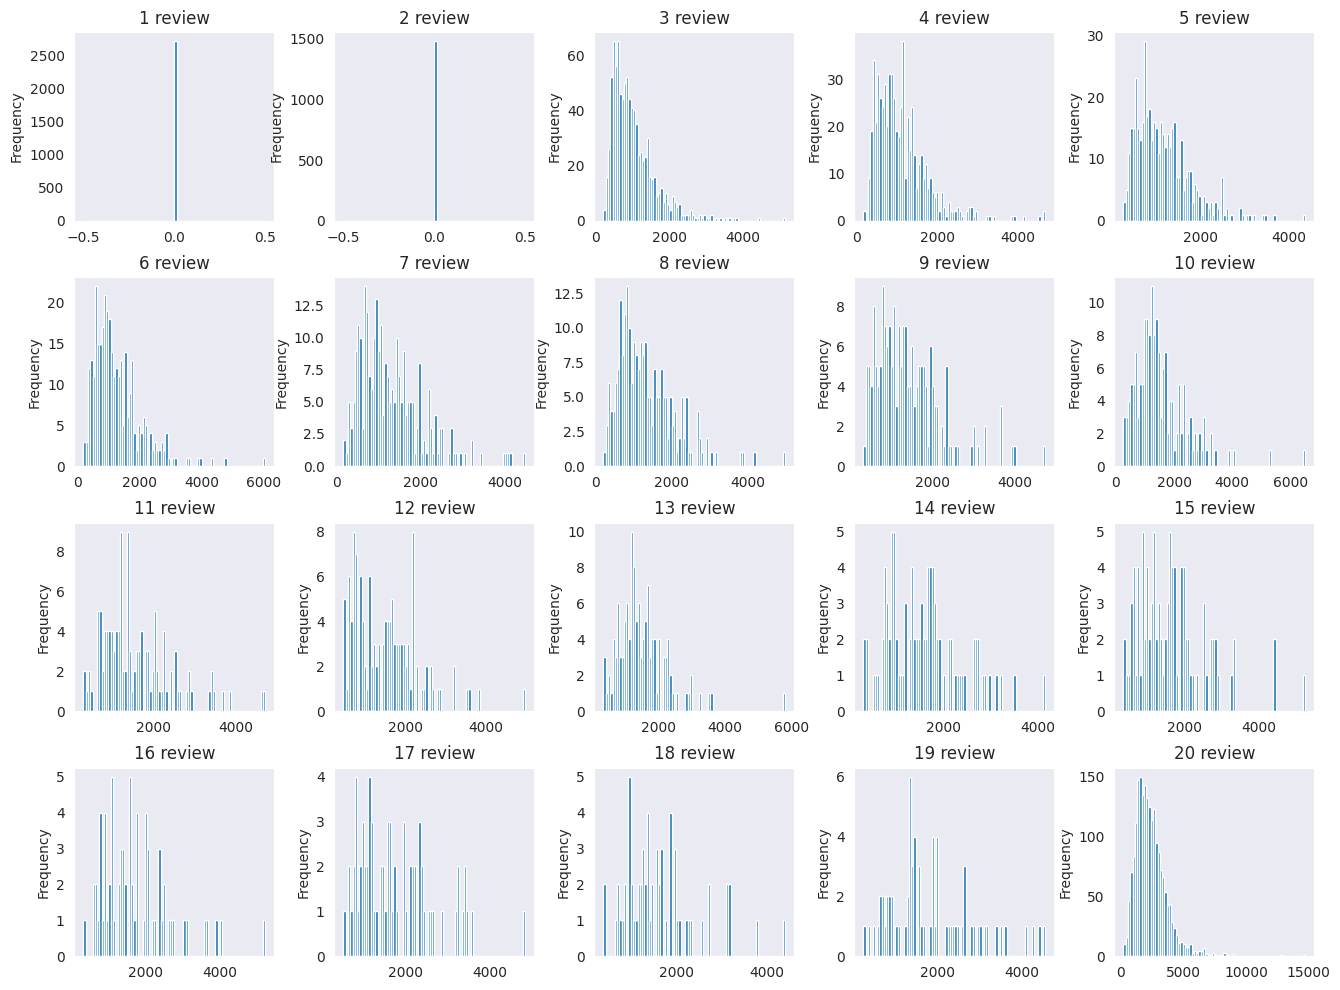

In [443]:
fig, axs = plt.subplots(4, 5, figsize=(16, 12))
axs = axs.ravel();
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
for i in range(1, 21):
    df["Words"].where(df["review_count"] == i).dropna().plot(ax=axs[i-1], kind="hist", bins=80, title=f"{i} review")

In [453]:
df_general.columns

Index(['Aired', 'Broadcast', 'Demographics', 'Description', 'Duration',
       'Episodes', 'Favorites', 'Genres', 'Members', 'Popularity', 'Ranked',
       'Rated', 'Rating', 'Score', 'Source', 'Studios', 'Synonyms', 'Themes',
       'Type', 'Premier season', 'Premier year', 'Premier month', 'Characters',
       'Character Description', 'Actors', 'Characters sum favorites',
       'Reviews'],
      dtype='object')

In [ ]:
df_general["Title"].where(df_general)

In [481]:
df_general["Premier year"].value_counts()

Unknown    2181
2017        870
2018        868
2016        868
2014        795
           ... 
1937          1
1930          1
1926          1
1951          1
1927          1
Name: Premier year, Length: 100, dtype: int64

In [471]:
df_general["Premier season"].value_counts()

Spring     4154
Fall       3839
Summer     3772
Winter     3551
Unknown    3420
Name: Premier season, dtype: int64

In [473]:
df_general["Premier month"].value_counts()

Unknown    2874
Apr        2266
Oct        2187
Jul        1980
Jan        1580
Mar        1284
Dec        1216
Aug        1050
Sep         974
Feb         888
Jun         879
Nov         821
May         737
Name: Premier month, dtype: int64

Dropping columns            
Aired cause Dah          
Broadcast cause why?             
Favorites cause it can create unwanted noise            
Members same reason                 
Popularity same reason            
Ranked unneeded             
Rated unneeded              
Score unneded            
Characters sum favorites no need          

In [458]:
df_general.drop(["Aired", 
                 "Broadcast", 
                 "Favorites", 
                 "Members", 
                 "Popularity", 
                 "Ranked", 
                 "Rated", 
                 "Score", 
                 "Characters sum favorites"],
                axis="columns",
                inplace=True)

In [466]:
df_general.reset_index(inplace=True)

In [484]:
df_general.to_json("Clean_anime_general.json")